# Preparation and EDA

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

from prophet import Prophet
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.metrics import mean_absolute_error, r2_score
from mango import Tuner

import geopandas as gpd

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
import torch
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from tqdm import tqdm

import time

d:\University\Diploma\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
data = pd.read_csv('../data/UkraineTuberByRegionByWeek.csv')

In [3]:
data.describe()

YEAR          WEEK        INFREL
count  60840.00000  60840.000000  60840.000000
mean    2002.00000     26.500000     19.211325
std       12.98728     15.008454     27.110223
min     1980.00000      1.000000      0.000000
25%     1991.00000     13.750000      3.000000
50%     2002.00000     26.500000     11.000000
75%     2013.00000     39.250000     24.000000
max     2024.00000     52.000000    379.000000

In [4]:
data['DATE'] = pd.to_datetime(data['YEAR'].astype(str) + '-' + data['WEEK'].astype(str) + '-1', format='%Y-%W-%w')
data = data.drop(columns=['YEAR', 'WEEK'], axis=1)

<Axes: xlabel='DATE'>

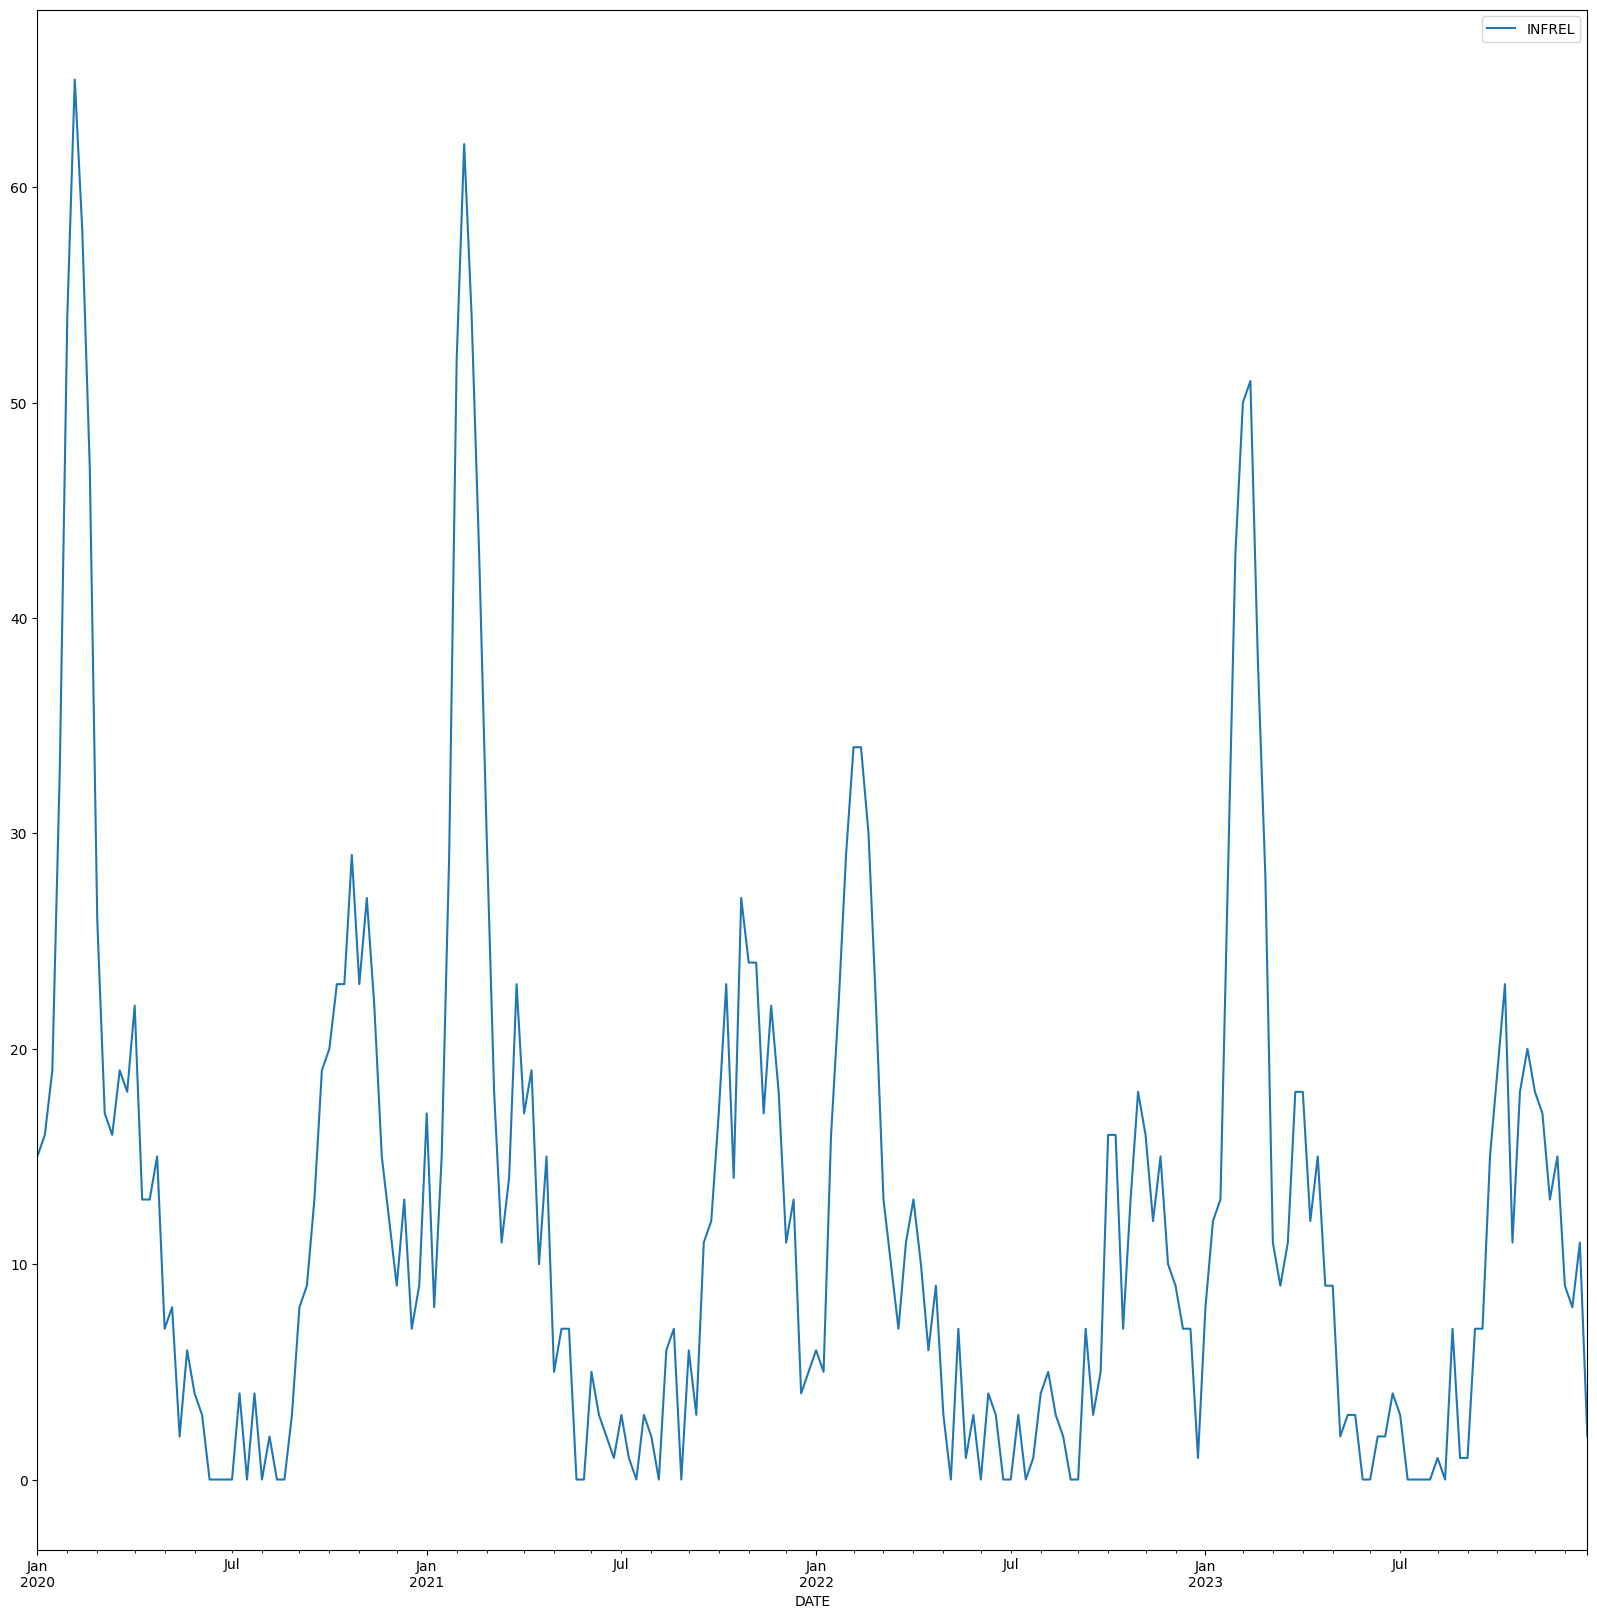

In [5]:
data[(data['REGION'] == 'Zaporizhzhia') & (data['DATE'] > '2020') & (data['DATE'] < '2024')].plot(x='DATE', y='INFREL', figsize=(20, 20))

In [6]:
data_by_region = {region: data[data['REGION'] == region] for region in data['REGION'].unique()}

In [7]:
data_by_region['Lviv'].head(10)

REGION  INFREL       DATE
728   Lviv      26 1980-01-07
729   Lviv      19 1980-01-14
730   Lviv      30 1980-01-21
731   Lviv      52 1980-01-28
732   Lviv      82 1980-02-04
733   Lviv      98 1980-02-11
734   Lviv      90 1980-02-18
735   Lviv      75 1980-02-25
736   Lviv      43 1980-03-03
737   Lviv      31 1980-03-10

In [8]:
data_by_region

{'AR Crimea':           REGION  INFREL       DATE
 0      AR Crimea      22 1980-01-07
 1      AR Crimea      19 1980-01-14
 2      AR Crimea      29 1980-01-21
 3      AR Crimea      48 1980-01-28
 4      AR Crimea      88 1980-02-04
 ...          ...     ...        ...
 59535  AR Crimea       0 2024-11-25
 59536  AR Crimea       0 2024-12-02
 59537  AR Crimea       0 2024-12-09
 59538  AR Crimea       0 2024-12-16
 59539  AR Crimea       0 2024-12-23
 
 [2340 rows x 3 columns],
 'Cherkasy':          REGION  INFREL       DATE
 52     Cherkasy      13 1980-01-07
 53     Cherkasy       5 1980-01-14
 54     Cherkasy      16 1980-01-21
 55     Cherkasy      26 1980-01-28
 56     Cherkasy      38 1980-02-04
 ...         ...     ...        ...
 59587  Cherkasy       1 2024-11-25
 59588  Cherkasy       7 2024-12-02
 59589  Cherkasy       6 2024-12-09
 59590  Cherkasy       3 2024-12-16
 59591  Cherkasy       3 2024-12-23
 
 [2340 rows x 3 columns],
 'Chernihiv':           REGION  INFREL     

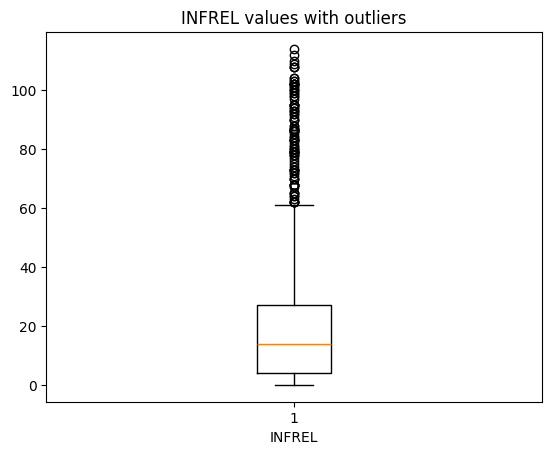

In [9]:
plt.boxplot(data_by_region['Zaporizhzhia']['INFREL'].values)

plt.title('INFREL values with outliers')
plt.xlabel('INFREL')

plt.show()

# DEFINING TRANING

In [10]:
def create_sequences(data, seq_length, predict_length):
    """
    Convert a 1D time series into input/output pairs using a sliding window.
    
    Parameters:
      data: 1D numpy array of time series data.
      seq_length: Number of time steps in the input sequence.
      predict_length: Number of time steps to predict.
      
    Returns:
      X: Array of input sequences of shape (num_samples, seq_length).
      y: Array of target sequences of shape (num_samples, predict_length).
    """
    X, y = [], []
    for i in range(len(data) - seq_length - predict_length + 1):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length : i + seq_length + predict_length])
    return np.array(X), np.array(y)

In [11]:
class SequenceDataset(Dataset):
    """
    Dataset for precomputed sequences.
    
    Each item is an (input, target) pair.
    """
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx].unsqueeze(-1), self.y[idx]

In [12]:
class AnchoredSequenceSplit:
    """
    Split sequences into training and test sets in an anchored (growing) fashion.
    """
    def __init__(self, n_splits):
        self.n_splits = n_splits
        
    def get_n_splits(self):
        return self.n_splits
    
    def split(self, X):
        n_samples = len(X)
        block_size = n_samples // (self.n_splits + 1)
        indices = np.arange(n_samples)
        for i in range(1, self.n_splits + 1):
            train_end = i * block_size
            test_end = (i + 1) * block_size
            yield indices[:train_end], indices[train_end:test_end]

# Additional functions

In [13]:
def plot_ukraine_r2_heatmap(geojson_path, region_r2_, algoithm_name='Prophet'):
    gdf = gpd.read_file(geojson_path)

    region_r2_['Autonomous Republic of Crimea'] = 0.0
    region_r2_['Kiev Oblast'] = region_r2_['Kyiv Oblast']
    region_r2_['Zaporizhia Oblast'] = region_r2_['Zaporizhzhia Oblast']
    r2_df = pd.DataFrame(list(region_r2_.items()), columns=["region", "r2_score"])

    gdf["region"] = gdf["name:en"].str.strip().str.lower() 
    r2_df["region"] = r2_df["region"].str.strip().str.lower()

    merged = gdf.merge(r2_df, on="region", how="left")

    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    merged.plot(column="r2_score", cmap="coolwarm", linewidth=0.8, edgecolor="black", legend=True, ax=ax)

    for _, row in merged.iterrows():
        centroid = row["geometry"].centroid 
        ax.text(centroid.x, centroid.y, f"{row['region'].title()}\n{row['r2_score']:.2f}",
                fontsize=8, ha='center', color="black", bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    ax.set_title(f"R² Score per Region in Ukraine for {algoithm_name}", fontsize=14)
    plt.axis("off")

    plt.show()

# PROPHET

In [ ]:
def validate_and_test_prophet(region_full_data, predict_length_val, predict_length_test, prophet_params, region, n_years_final_train=None):
    """
    Train on last n_years_final_train years before validation, validate on 2023, test on 2024.
    
    Parameters:
        region_full_data: DataFrame with columns ['ds', 'y'] from 1980–2024
        predict_length_val: Number of weeks in validation set (e.g., 52 for 2023)
        predict_length_test: Number of weeks in test set (e.g., 52 for 2024)
        prophet_params: Parameters to initialize Prophet
        region: Name of the region (for logging/plotting)
        n_years_final_train: Use only this many most recent years before validation for training. If None, use full history.

    Returns:
        Dictionary with validation and test metrics.
    """
    region_full_data = pd.DataFrame(region_full_data, columns=["ds", "y"])
    
    total_length = len(region_full_data)
    test_start = total_length - predict_length_test
    val_start = test_start - predict_length_val

    if n_years_final_train is not None:
        weeks_per_year = 52 
        train_weeks = n_years_final_train * weeks_per_year
        train_start = max(0, val_start - train_weeks)
    else:
        train_start = 0

    train_data = region_full_data.iloc[train_start:val_start]
    val_data = region_full_data.iloc[val_start:test_start]
    test_data = region_full_data.iloc[test_start:]

    model = Prophet(**prophet_params)
    model.fit(train_data)

    val_future = val_data[['ds']]
    val_forecast = model.predict(val_future)[['ds', 'yhat']]
    val_forecast['yhat'] = val_forecast['yhat'].clip(lower=0)
    val_merged = val_data.merge(val_forecast, on='ds')
    
    val_mae = mean_absolute_error(val_merged['y'], val_merged['yhat'])
    val_r2 = r2_score(val_merged['y'], val_merged['yhat'])

    test_future = test_data[['ds']]
    test_forecast = model.predict(test_future)[['ds', 'yhat']]
    test_forecast['yhat'] = test_forecast['yhat'].clip(lower=0)
    test_merged = test_data.merge(test_forecast, on='ds')
    
    test_mae = mean_absolute_error(test_merged['y'], test_merged['yhat'])
    test_r2 = r2_score(test_merged['y'], test_merged['yhat'])

    print(f"\nValidation (2023) - {region}: MAE = {val_mae:.4f}, R^2 = {val_r2:.4f}")
    print(f"Test (2024)       - {region}: MAE = {test_mae:.4f}, R^2 = {test_r2:.4f}")

    if region in ['Zaporizhzhia', 'Lviv', 'Kyiv']:
        plt.figure(figsize=(14, 6))
        plt.plot(test_merged['ds'], test_merged['y'], label='Actual (2024)', marker='o')
        plt.plot(test_merged['ds'], test_merged['yhat'], label='Predicted (2024)', marker='x')
        plt.title(f'2024 Test Forecast - {region}')
        plt.xlabel('Date')
        plt.ylabel('Cases')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return {
        "val": {"mae": val_mae, "r2": val_r2},
        "test": {"mae": test_mae, "r2": test_r2}
    }

In [24]:
def objective_function(args_list, train_data, val_data, PREDICT_LENGTH):
    results = []
    
    for params in args_list:
        try:
            model = Prophet(**params)
            model.fit(train_data)
            future = val_data[['ds']]
            forecast = model.predict(future)
            predictions_tuned = forecast.tail(PREDICT_LENGTH)
            error = mean_absolute_error(val_data['y'], predictions_tuned['yhat'])   
            results.append(error)
        except:
            results.append(25.0)  # Assign high loss for invalid parameter sets

    return results

In [25]:
from scipy.stats import uniform

param_space = {
    'seasonality_prior_scale': uniform(5.0, 15.0),
    'changepoint_prior_scale': uniform(0.01, 0.1),
    'interval_width': uniform(0.2, 0.8)
}

conf_Dict = {'initial_random': 10, 'num_iteration': 50}

In [26]:
def tune_model(train_data, val_data, PREDICT_LENGTH):
    tuner = Tuner(param_space, lambda args: objective_function(args, train_data, val_data, PREDICT_LENGTH), conf_Dict)
    results = tuner.minimize()
    return results['best_params'], results['best_objective']

In [29]:
PREDICT_LENGTH = 52
PROPHET_PARAMS = {
    'seasonality_mode': 'multiplicative',
    'yearly_seasonality': True,
    'weekly_seasonality': False,
    'daily_seasonality': True,
    'growth': 'linear',
}
regions_mae_val = {}
regions_r2_val = {}

regions_mae_test = {}
regions_r2_test = {}

Best score: 25.0: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it]


Region: Cherkasy | Best Params: {'changepoint_prior_scale': 0.08231933899234298, 'interval_width': 0.606139504865207, 'seasonality_prior_scale': 15.566609660432388} | Best Loss: 25.0


15:26:33 - cmdstanpy - INFO - Chain [1] start processing
15:26:34 - cmdstanpy - INFO - Chain [1] done processing



Validation (2023) - Cherkasy: MAE = 2.0996, R^2 = 0.8333
Test (2024)       - Cherkasy: MAE = 2.1867, R^2 = 0.4010


Best score: 25.0: 100%|██████████| 50/50 [01:25<00:00,  1.71s/it]


Region: Chernihiv | Best Params: {'changepoint_prior_scale': 0.08953359189715535, 'interval_width': 0.20594808598817613, 'seasonality_prior_scale': 17.670520306234664} | Best Loss: 25.0


15:28:02 - cmdstanpy - INFO - Chain [1] start processing
15:28:03 - cmdstanpy - INFO - Chain [1] done processing



Validation (2023) - Chernihiv: MAE = 2.4810, R^2 = 0.7617
Test (2024)       - Chernihiv: MAE = 2.0021, R^2 = 0.5950


Best score: 25.0: 100%|██████████| 50/50 [01:28<00:00,  1.78s/it]


Region: Chernivtsi | Best Params: {'changepoint_prior_scale': 0.0637360233600216, 'interval_width': 0.8260705123793153, 'seasonality_prior_scale': 16.255927665000044} | Best Loss: 25.0


15:29:34 - cmdstanpy - INFO - Chain [1] start processing
15:29:34 - cmdstanpy - INFO - Chain [1] done processing



Validation (2023) - Chernivtsi: MAE = 1.8776, R^2 = 0.5832
Test (2024)       - Chernivtsi: MAE = 1.8653, R^2 = 0.0966


Best score: 25.0: 100%|██████████| 50/50 [01:27<00:00,  1.75s/it]


Region: Dnipropetrovsk | Best Params: {'changepoint_prior_scale': 0.05219031666582621, 'interval_width': 0.32564962306720024, 'seasonality_prior_scale': 8.205672635297061} | Best Loss: 25.0


15:31:04 - cmdstanpy - INFO - Chain [1] start processing
15:31:05 - cmdstanpy - INFO - Chain [1] done processing



Validation (2023) - Dnipropetrovsk: MAE = 9.2812, R^2 = 0.7920
Test (2024)       - Dnipropetrovsk: MAE = 21.8975, R^2 = -2.6292


Best score: 25.0: 100%|██████████| 50/50 [01:25<00:00,  1.70s/it]


Region: Donetsk | Best Params: {'changepoint_prior_scale': 0.1068059367161294, 'interval_width': 0.7485977988933006, 'seasonality_prior_scale': 11.744904275882714} | Best Loss: 25.0


15:32:32 - cmdstanpy - INFO - Chain [1] start processing
15:32:34 - cmdstanpy - INFO - Chain [1] done processing



Validation (2023) - Donetsk: MAE = 10.3219, R^2 = 0.1585
Test (2024)       - Donetsk: MAE = 6.9297, R^2 = -0.0216


Best score: 25.0: 100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


Region: Ivano-Frankivsk | Best Params: {'changepoint_prior_scale': 0.0263113575044282, 'interval_width': 0.4163909070357814, 'seasonality_prior_scale': 15.269623713332647} | Best Loss: 25.0


15:34:01 - cmdstanpy - INFO - Chain [1] start processing
15:34:01 - cmdstanpy - INFO - Chain [1] done processing



Validation (2023) - Ivano-Frankivsk: MAE = 2.6102, R^2 = 0.6178
Test (2024)       - Ivano-Frankivsk: MAE = 2.2827, R^2 = 0.3979


Best score: 25.0: 100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


Region: Kharkiv | Best Params: {'changepoint_prior_scale': 0.10990808930883961, 'interval_width': 0.7498725178026666, 'seasonality_prior_scale': 11.352141082670801} | Best Loss: 25.0


15:35:28 - cmdstanpy - INFO - Chain [1] start processing
15:35:29 - cmdstanpy - INFO - Chain [1] done processing



Validation (2023) - Kharkiv: MAE = 2.8752, R^2 = 0.9139
Test (2024)       - Kharkiv: MAE = 2.6530, R^2 = 0.8503


Best score: 25.0: 100%|██████████| 50/50 [01:26<00:00,  1.72s/it]


Region: Kherson | Best Params: {'changepoint_prior_scale': 0.06946164912666455, 'interval_width': 0.7361538508832524, 'seasonality_prior_scale': 14.659168047247345} | Best Loss: 25.0


15:36:57 - cmdstanpy - INFO - Chain [1] start processing
15:36:58 - cmdstanpy - INFO - Chain [1] done processing



Validation (2023) - Kherson: MAE = 4.4118, R^2 = 0.5496
Test (2024)       - Kherson: MAE = 2.6634, R^2 = 0.4977


Best score: 25.0: 100%|██████████| 50/50 [01:20<00:00,  1.62s/it]


Region: Khmelnytskyi | Best Params: {'changepoint_prior_scale': 0.09971846208492105, 'interval_width': 0.22431013960837545, 'seasonality_prior_scale': 5.316856397275338} | Best Loss: 25.0


15:38:21 - cmdstanpy - INFO - Chain [1] start processing
15:38:22 - cmdstanpy - INFO - Chain [1] done processing



Validation (2023) - Khmelnytskyi: MAE = 2.9702, R^2 = 0.6302
Test (2024)       - Khmelnytskyi: MAE = 2.4220, R^2 = 0.5385


Best score: 25.0: 100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


Region: Kirovohrad | Best Params: {'changepoint_prior_scale': 0.07835004349003281, 'interval_width': 0.25321202993915437, 'seasonality_prior_scale': 11.899512178424672} | Best Loss: 25.0


15:39:49 - cmdstanpy - INFO - Chain [1] start processing
15:39:50 - cmdstanpy - INFO - Chain [1] done processing



Validation (2023) - Kirovohrad: MAE = 2.2142, R^2 = 0.8615
Test (2024)       - Kirovohrad: MAE = 2.6446, R^2 = 0.3361


Best score: 25.0: 100%|██████████| 50/50 [01:23<00:00,  1.67s/it]


Region: Kyiv | Best Params: {'changepoint_prior_scale': 0.08065157056292584, 'interval_width': 0.2578059366245226, 'seasonality_prior_scale': 10.670812190811464} | Best Loss: 25.0


15:41:16 - cmdstanpy - INFO - Chain [1] start processing
15:41:17 - cmdstanpy - INFO - Chain [1] done processing



Validation (2023) - Kyiv: MAE = 2.5102, R^2 = 0.9255
Test (2024)       - Kyiv: MAE = 3.5258, R^2 = 0.5714


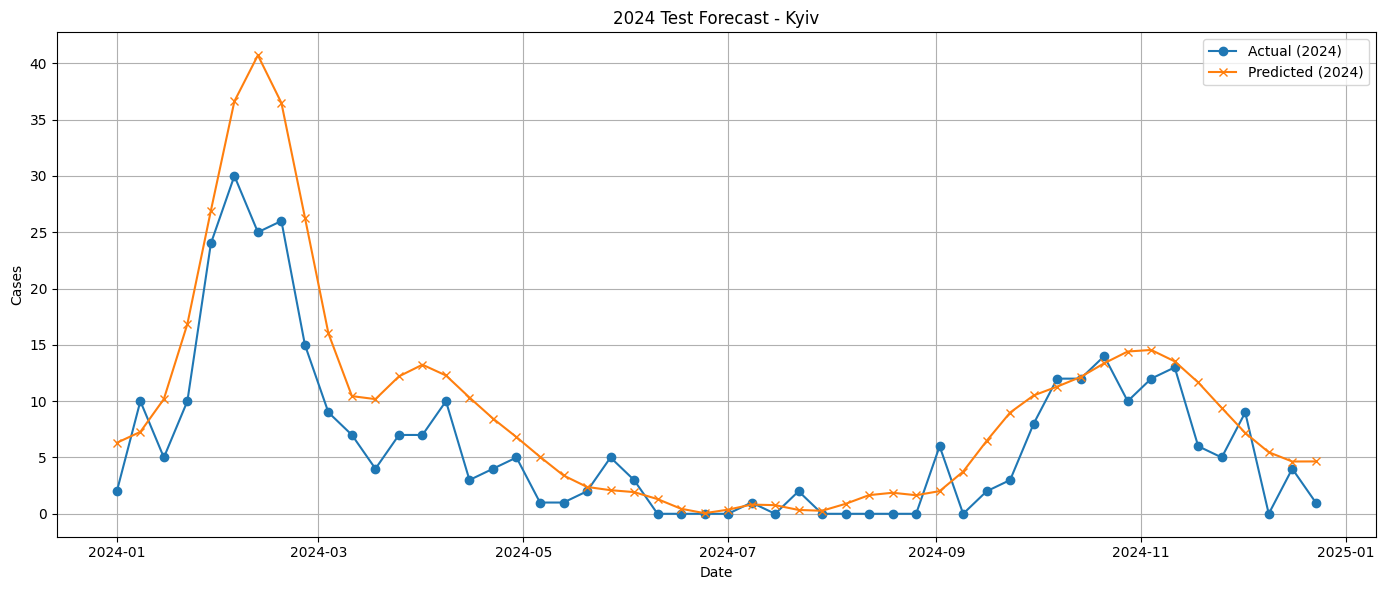

Best score: 25.0: 100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


Region: KyivCity | Best Params: {'changepoint_prior_scale': 0.015805218926368172, 'interval_width': 0.2345418103276983, 'seasonality_prior_scale': 14.809930139991758} | Best Loss: 25.0


15:42:43 - cmdstanpy - INFO - Chain [1] start processing
15:42:44 - cmdstanpy - INFO - Chain [1] done processing



Validation (2023) - KyivCity: MAE = 2.4522, R^2 = 0.9138
Test (2024)       - KyivCity: MAE = 2.5248, R^2 = 0.8062


Best score: 25.0: 100%|██████████| 50/50 [01:22<00:00,  1.66s/it]


Region: Luhansk | Best Params: {'changepoint_prior_scale': 0.01545591534002442, 'interval_width': 0.2501644722942371, 'seasonality_prior_scale': 18.45620588798059} | Best Loss: 25.0


15:44:09 - cmdstanpy - INFO - Chain [1] start processing
15:44:11 - cmdstanpy - INFO - Chain [1] done processing



Validation (2023) - Luhansk: MAE = 3.3668, R^2 = 0.1612
Test (2024)       - Luhansk: MAE = 2.7394, R^2 = -0.4303


Best score: 25.0: 100%|██████████| 50/50 [01:23<00:00,  1.66s/it]


Region: Lviv | Best Params: {'changepoint_prior_scale': 0.055702745620506186, 'interval_width': 0.9337540063590624, 'seasonality_prior_scale': 13.587270065553472} | Best Loss: 25.0


15:45:36 - cmdstanpy - INFO - Chain [1] start processing
15:45:37 - cmdstanpy - INFO - Chain [1] done processing



Validation (2023) - Lviv: MAE = 3.9412, R^2 = 0.8876
Test (2024)       - Lviv: MAE = 5.1146, R^2 = 0.3819


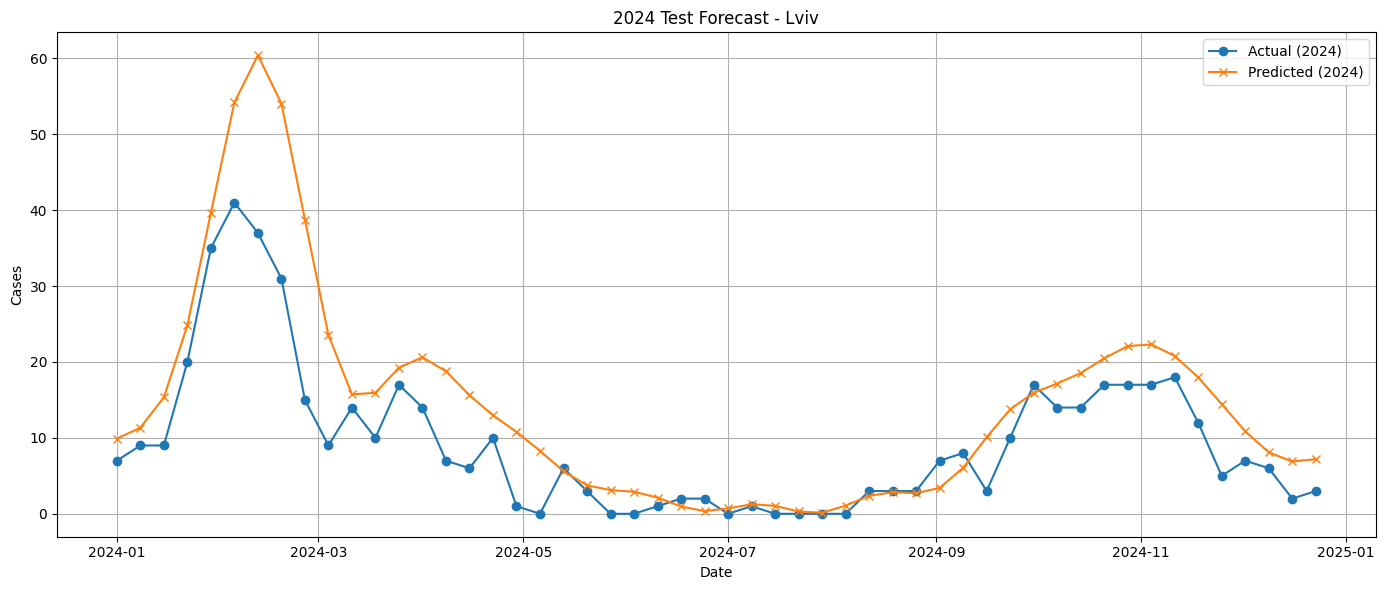

Best score: 25.0: 100%|██████████| 50/50 [01:25<00:00,  1.71s/it]


Region: Mykolaiv | Best Params: {'changepoint_prior_scale': 0.09619875572399207, 'interval_width': 0.41689823249542796, 'seasonality_prior_scale': 14.941807280790236} | Best Loss: 25.0


15:47:05 - cmdstanpy - INFO - Chain [1] start processing
15:47:06 - cmdstanpy - INFO - Chain [1] done processing



Validation (2023) - Mykolaiv: MAE = 2.3337, R^2 = 0.8670
Test (2024)       - Mykolaiv: MAE = 2.5232, R^2 = 0.4921


Best score: 25.0: 100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


Region: Odessa | Best Params: {'changepoint_prior_scale': 0.056435368806124195, 'interval_width': 0.8794409303159425, 'seasonality_prior_scale': 13.195587747211887} | Best Loss: 25.0


15:48:33 - cmdstanpy - INFO - Chain [1] start processing
15:48:34 - cmdstanpy - INFO - Chain [1] done processing



Validation (2023) - Odessa: MAE = 7.6042, R^2 = 0.8331
Test (2024)       - Odessa: MAE = 16.4695, R^2 = -0.6111


Best score: 25.0: 100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


Region: Poltava | Best Params: {'changepoint_prior_scale': 0.05706605128263804, 'interval_width': 0.6019937876027256, 'seasonality_prior_scale': 13.533995112350523} | Best Loss: 25.0


15:50:00 - cmdstanpy - INFO - Chain [1] start processing
15:50:02 - cmdstanpy - INFO - Chain [1] done processing



Validation (2023) - Poltava: MAE = 2.6586, R^2 = 0.8252
Test (2024)       - Poltava: MAE = 3.4080, R^2 = -0.3749


Best score: 25.0: 100%|██████████| 50/50 [01:26<00:00,  1.73s/it]


Region: Rivne | Best Params: {'changepoint_prior_scale': 0.029774719952650998, 'interval_width': 0.9326153354143161, 'seasonality_prior_scale': 15.461076777105362} | Best Loss: 25.0


15:51:30 - cmdstanpy - INFO - Chain [1] start processing
15:51:30 - cmdstanpy - INFO - Chain [1] done processing



Validation (2023) - Rivne: MAE = 2.2201, R^2 = 0.8230
Test (2024)       - Rivne: MAE = 1.9944, R^2 = 0.3437


Best score: 25.0: 100%|██████████| 50/50 [01:25<00:00,  1.70s/it]


Region: Sumy | Best Params: {'changepoint_prior_scale': 0.09171045648105107, 'interval_width': 0.5726234631390279, 'seasonality_prior_scale': 18.734668623093185} | Best Loss: 25.0


15:52:58 - cmdstanpy - INFO - Chain [1] start processing
15:52:58 - cmdstanpy - INFO - Chain [1] done processing



Validation (2023) - Sumy: MAE = 2.1190, R^2 = 0.8231
Test (2024)       - Sumy: MAE = 2.6206, R^2 = -0.3060


Best score: 25.0: 100%|██████████| 50/50 [01:23<00:00,  1.68s/it]


Region: Ternopil | Best Params: {'changepoint_prior_scale': 0.05396131650634361, 'interval_width': 0.5562377603998414, 'seasonality_prior_scale': 14.089131164876232} | Best Loss: 25.0


15:54:24 - cmdstanpy - INFO - Chain [1] start processing
15:54:25 - cmdstanpy - INFO - Chain [1] done processing



Validation (2023) - Ternopil: MAE = 2.0836, R^2 = 0.4487
Test (2024)       - Ternopil: MAE = 1.7349, R^2 = 0.0958


Best score: 25.0: 100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


Region: Vinnytsia | Best Params: {'changepoint_prior_scale': 0.09140606661091709, 'interval_width': 0.2224076966814689, 'seasonality_prior_scale': 9.876731949740227} | Best Loss: 25.0


15:55:51 - cmdstanpy - INFO - Chain [1] start processing
15:55:52 - cmdstanpy - INFO - Chain [1] done processing



Validation (2023) - Vinnytsia: MAE = 1.9609, R^2 = 0.8682
Test (2024)       - Vinnytsia: MAE = 1.9825, R^2 = 0.7082


Best score: 25.0: 100%|██████████| 50/50 [01:26<00:00,  1.73s/it]


Region: Volyn | Best Params: {'changepoint_prior_scale': 0.06952858345028168, 'interval_width': 0.8626327324128609, 'seasonality_prior_scale': 12.284524307079046} | Best Loss: 25.0


15:57:20 - cmdstanpy - INFO - Chain [1] start processing
15:57:21 - cmdstanpy - INFO - Chain [1] done processing



Validation (2023) - Volyn: MAE = 2.6037, R^2 = 0.7240
Test (2024)       - Volyn: MAE = 2.8888, R^2 = 0.2455


Best score: 25.0: 100%|██████████| 50/50 [01:24<00:00,  1.68s/it]


Region: Zakarpattia | Best Params: {'changepoint_prior_scale': 0.021332607420211327, 'interval_width': 0.8122523266340025, 'seasonality_prior_scale': 17.931693010682068} | Best Loss: 25.0


15:58:47 - cmdstanpy - INFO - Chain [1] start processing
15:58:48 - cmdstanpy - INFO - Chain [1] done processing



Validation (2023) - Zakarpattia: MAE = 5.5882, R^2 = 0.3004
Test (2024)       - Zakarpattia: MAE = 8.7015, R^2 = -2.9341


Best score: 25.0: 100%|██████████| 50/50 [01:25<00:00,  1.70s/it]


Region: Zaporizhzhia | Best Params: {'changepoint_prior_scale': 0.02345783960585971, 'interval_width': 0.5427279962035836, 'seasonality_prior_scale': 14.971721519659326} | Best Loss: 25.0


16:00:15 - cmdstanpy - INFO - Chain [1] start processing
16:00:16 - cmdstanpy - INFO - Chain [1] done processing



Validation (2023) - Zaporizhzhia: MAE = 2.8105, R^2 = 0.9051
Test (2024)       - Zaporizhzhia: MAE = 2.6129, R^2 = 0.7085


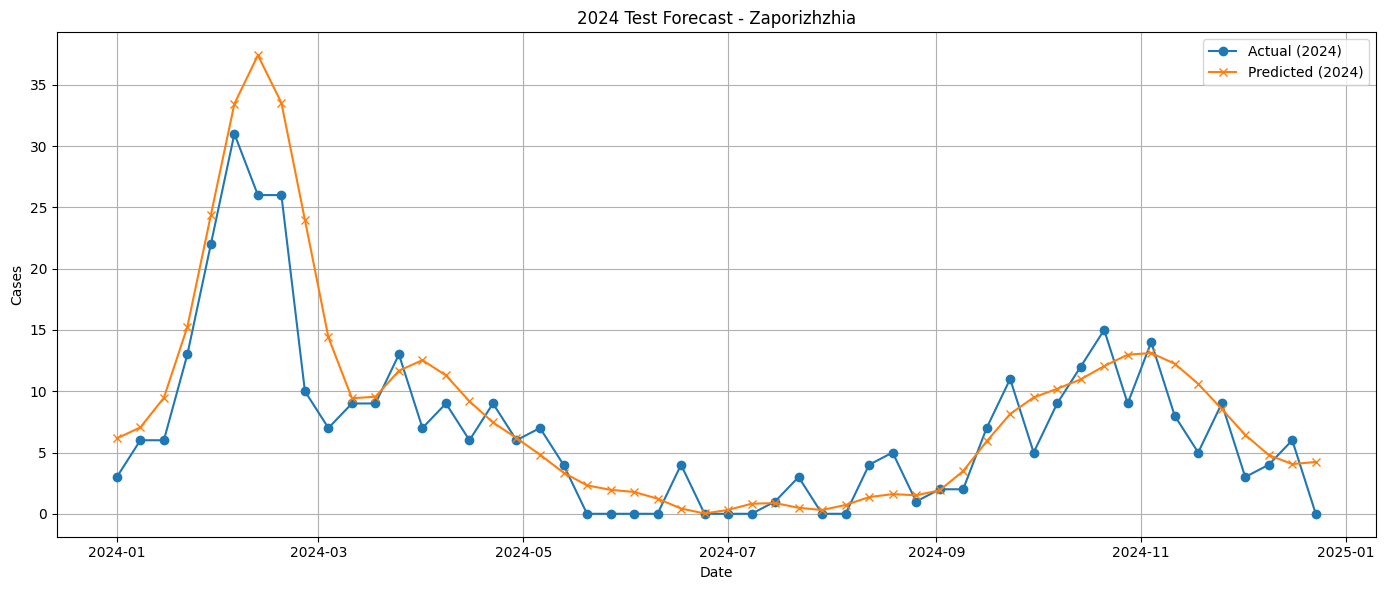

Best score: 25.0: 100%|██████████| 50/50 [01:25<00:00,  1.70s/it]


Region: Zhytomyr | Best Params: {'changepoint_prior_scale': 0.04543175774195067, 'interval_width': 0.2507675324755865, 'seasonality_prior_scale': 18.526815478255195} | Best Loss: 25.0


16:01:44 - cmdstanpy - INFO - Chain [1] start processing
16:01:44 - cmdstanpy - INFO - Chain [1] done processing



Validation (2023) - Zhytomyr: MAE = 2.3991, R^2 = 0.8381
Test (2024)       - Zhytomyr: MAE = 2.9779, R^2 = 0.4306


In [ ]:
for region in data_by_region.keys():
    if region == 'AR Crimea':
        continue
    
    train_data = data_by_region[region][['DATE', 'INFREL']].iloc[:-PREDICT_LENGTH]  
    test_data = data_by_region[region][['DATE', 'INFREL']].iloc[-PREDICT_LENGTH:] 
    
    best_params, best_loss = tune_model(train_data, test_data, PREDICT_LENGTH)
    
    print(f"Region: {region} | Best Params: {best_params} | Best Loss: {best_loss}")
    
    PROPHET_PARAMS.update(best_params)
    prophet_history = validate_and_test_prophet(data_by_region[region][['DATE', 'INFREL']].values, PREDICT_LENGTH, PREDICT_LENGTH, PROPHET_PARAMS, region, 12)
    
    regions_mae_val[region] = prophet_history['val']['mae']
    regions_r2_val[region] = prophet_history['val']['r2']

    regions_mae_test[region] = prophet_history['test']['mae']
    regions_r2_test[region] = prophet_history['test']['r2']

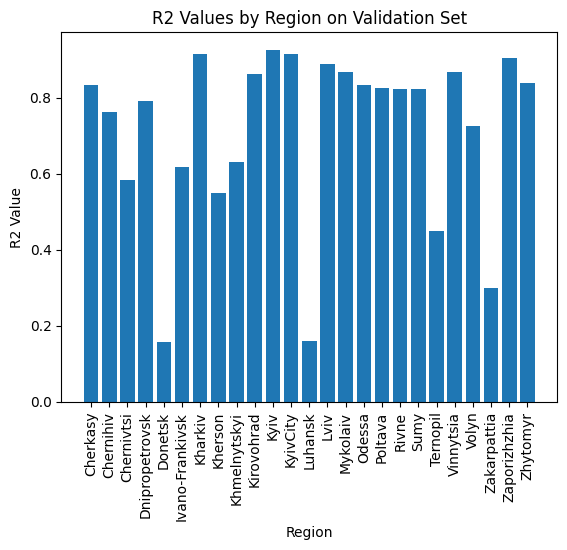

In [31]:
plt.bar(list(data_by_region.keys())[1:], np.array([regions_r2_val[region] for region in regions_r2_val.keys()]).clip(min=0))

plt.title('R2 Values by Region on Validation Set')
plt.xlabel('Region')
plt.ylabel('R2 Value')
plt.xticks(rotation=90)
plt.show()

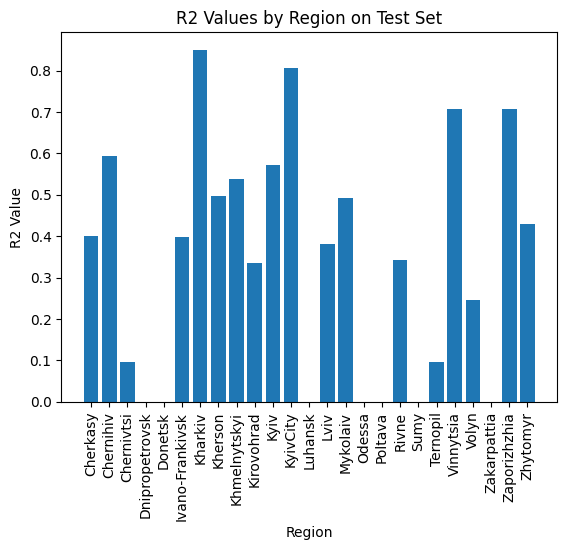

In [32]:
plt.bar(list(data_by_region.keys())[1:], np.array([regions_r2_test[region] for region in regions_r2_test.keys()]).clip(min=0))

plt.title('R2 Values by Region on Test Set')
plt.xlabel('Region')
plt.ylabel('R2 Value')
plt.xticks(rotation=90)
plt.show()

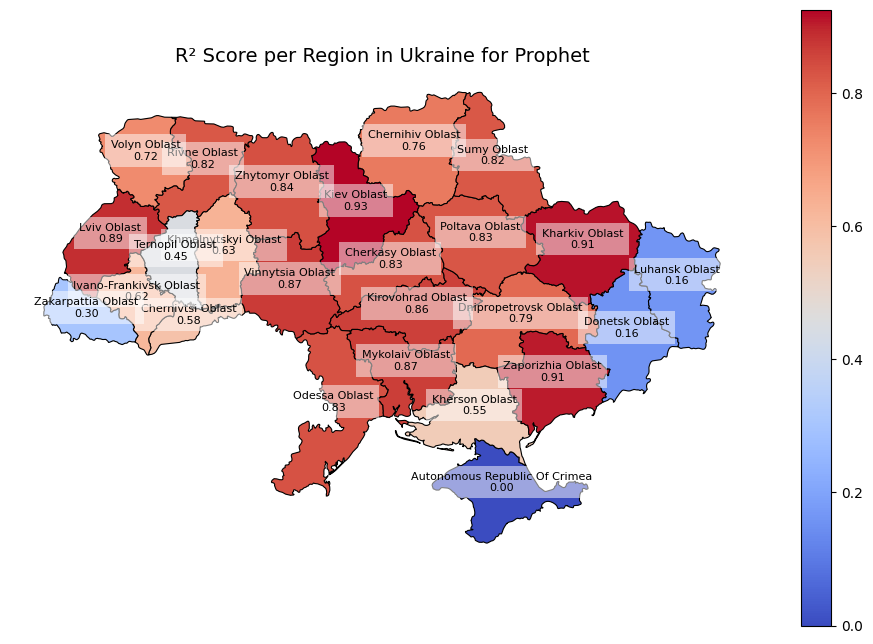

In [42]:
regions_to_r2_val = {f'{region} Oblast': max(0, float(regions_r2_val[region])) for region in regions_r2_val.keys() if region != 'KyivCity'}
plot_ukraine_r2_heatmap('D:/University/Diploma/data/UA_FULL_Ukraine.geojson', regions_to_r2_val)

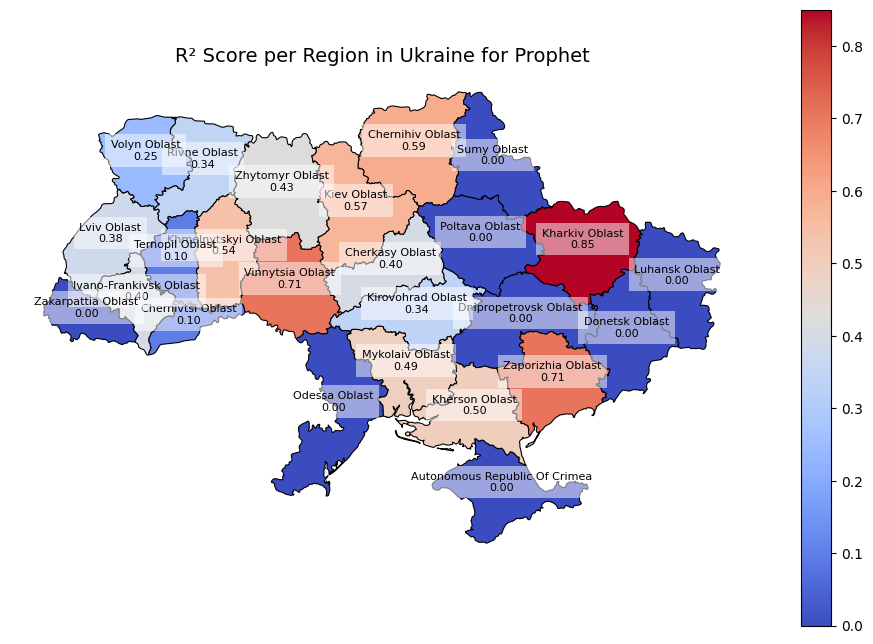

In [43]:
regions_to_r2_test = {f'{region} Oblast': max(0, float(regions_r2_test[region])) for region in regions_r2_test.keys() if region != 'KyivCity'}
plot_ukraine_r2_heatmap('D:/University/Diploma/data/UA_FULL_Ukraine.geojson', regions_to_r2_test)

# SARIMA

In [14]:
def seasonal_decomposition(region, model="multiplicative", period=52):
    dates = data_by_region[region]["DATE"].sort_values().values
    region_data = data_by_region[region].sort_values(by="DATE").apply(lambda x: x['INFREL']+0.001 if (x['INFREL'] == 0 and model == "multiplicative") else x['INFREL'], axis=1)
    time_series = region_data.values

    result = seasonal_decompose(time_series, model=model, period=period)

    fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

    axes[0].plot(dates, result.observed, label="Observed", color="black")
    axes[0].set_title("Observed")

    axes[1].plot(dates, result.trend, label="Trend", color="blue")
    axes[1].set_title("Trend")

    axes[2].plot(dates, result.seasonal, label="Seasonality", color="green")
    axes[2].set_title("Seasonality")

    axes[3].plot(dates, result.resid, label="Residuals", color="red")
    axes[3].set_title("Residuals")

    plt.xlabel("Date")
    plt.tight_layout()
    plt.show()

    return result

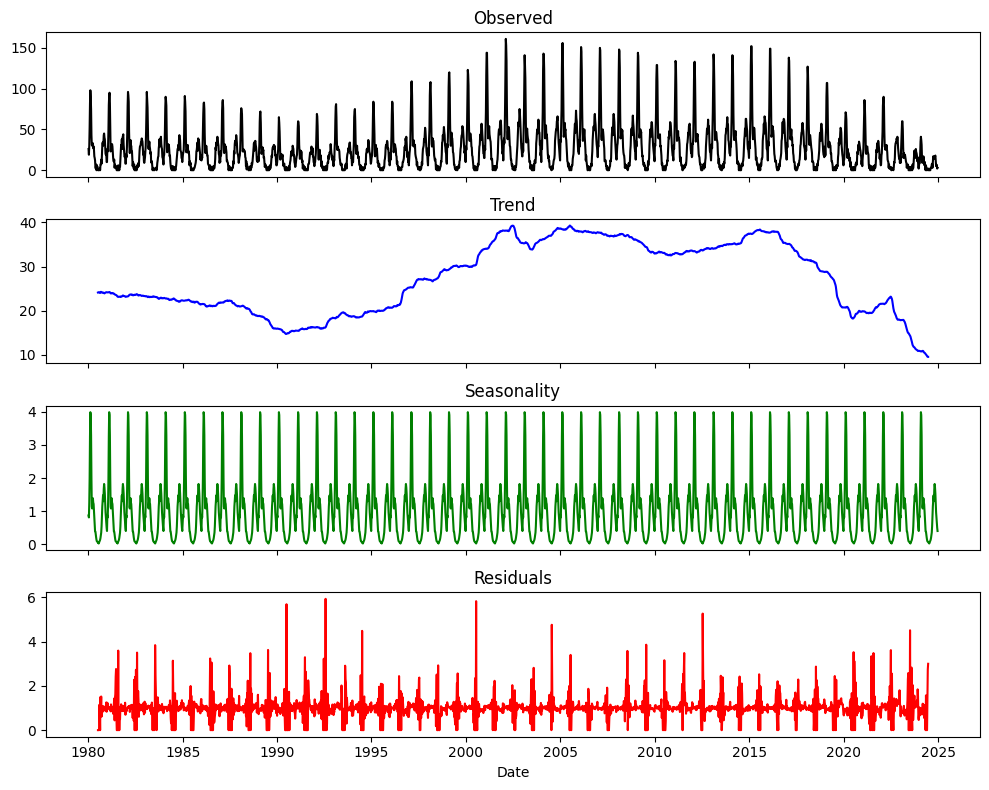

In [15]:
result = seasonal_decomposition(region="Lviv", model='multiplicative', period=52)

There is seasonality in this data, so it can't be stationary.

To make data stationary we need to get rid off seasonality and trend

In [16]:
def clear_trend_seasonality(region, period=52):
    region_data = data_by_region[region].sort_values(by="DATE").copy(deep=True)

    # Apply log transformation to handle multiplicative seasonality
    region_data["INFREL"] = np.log1p(region_data["INFREL"])

    # Plot original (log-transformed) data
    # plt.figure(figsize=(10, 4))
    # plt.plot(region_data["DATE"], region_data["INFREL"], label="Log-Transformed INFREL")
    # plt.legend()
    # plt.show()

    # First-order differencing (to remove trend)
    deseasonalized_data = region_data.copy()
    deseasonalized_data["INFREL"] = region_data["INFREL"].diff()

    deseasonalized_data = deseasonalized_data.dropna()

    plt.figure(figsize=(10, 4))
    plt.plot(deseasonalized_data["DATE"], deseasonalized_data["INFREL"], label="Deseasonalized INFREL")
    plt.legend()
    plt.show()

    # Seasonal differencing (to remove seasonal effect)
    # detrended_data = deseasonalized_data.copy()
    detrended_data = region_data.copy()
    detrended_data["INFREL"] = deseasonalized_data["INFREL"].diff(period)

    # Drop NaN values
    detrended_data = detrended_data.dropna()

    # Plot transformed data
    # plt.figure(figsize=(10, 4))
    # plt.plot(detrended_data["DATE"], detrended_data["INFREL"], label="Detrended INFREL")
    # plt.legend()
    # plt.show()

    return detrended_data

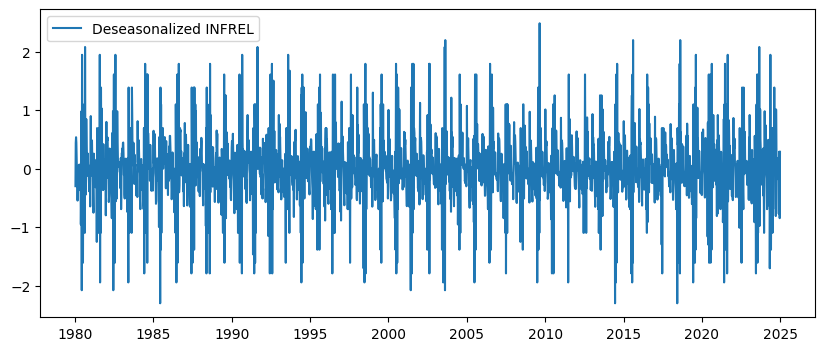

REGION    INFREL       DATE
2081    Lviv  0.182322 1981-01-12
2082    Lviv -0.182322 1981-01-19
2083    Lviv -0.058269 1981-01-26
2084    Lviv  0.033877 1981-02-02
2085    Lviv -0.048940 1981-02-09
...      ...       ...        ...
60263   Lviv -0.313658 2024-11-25
60264   Lviv -0.060625 2024-12-02
60265   Lviv  0.214775 2024-12-09
60266   Lviv  0.251314 2024-12-16
60267   Lviv  0.575364 2024-12-23

[2287 rows x 3 columns]

In [17]:
clear_trend_seasonality(region="Lviv", period=52)

In [18]:
def plot_acf_pacf(df): 
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))

    plot_acf(df["INFREL"].dropna(), lags=156, ax=ax[0])  # ACF for MA(q)
    ax[0].set_title("Autocorrelation Function (ACF)")

    plot_pacf(df["INFREL"].dropna(), lags=156, ax=ax[1])  # PACF for AR(p)
    ax[1].set_title("Partial Autocorrelation Function (PACF)")

    plt.show()

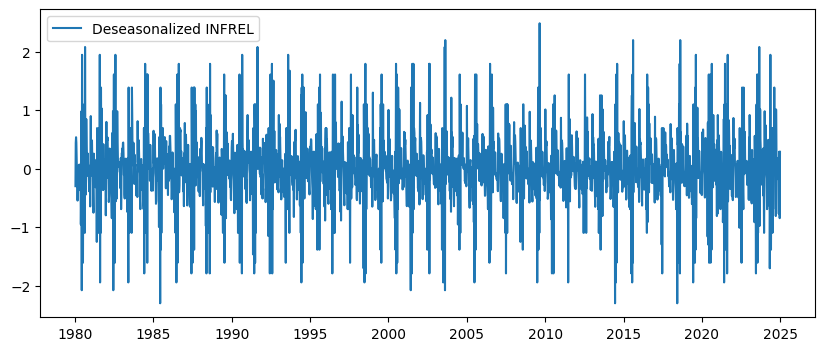

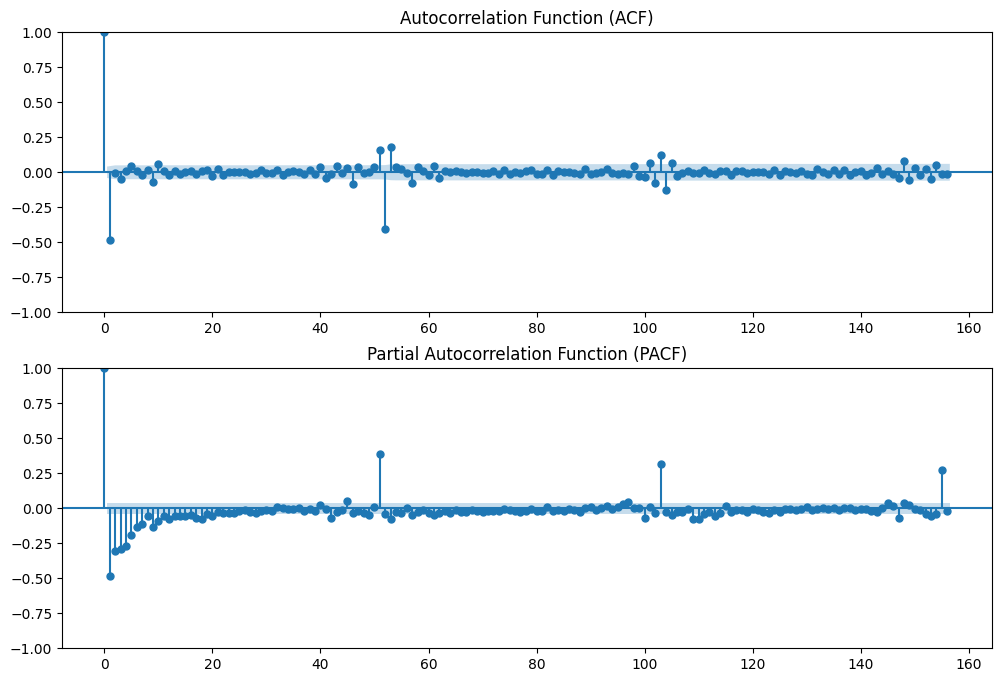

In [19]:
plot_acf_pacf(clear_trend_seasonality(region="Lviv", period=52))

In [ ]:
def sarima_forecast(data, region, order=(1, 1, 1), seasonal_order=(0, 1, 1, 52), test_period=52, n_years_final_train=None):
    """
    Train SARIMA on the raw dataset (no detrending or deseasonalizing), validate on the last 52 observations,
    and test on the next period (e.g., 52 weeks after validation).

    Args:
        data (DataFrame): DataFrame with 'DATE' and 'INFREL' columns.
        region (str): Name of the region.
        order (tuple): Non-seasonal ARIMA order (p, d, q).
        seasonal_order (tuple): Seasonal order (P, D, Q, s).
        test_period (int): The number of periods for the test set (default 52).
        n_years_final_train=None (int): Number of years to include in the final training set. If None, use all data before validation.

    Returns:
        results_df (DataFrame): DataFrame with predictions and actuals for both validation and test periods.
        model_fit: Fitted SARIMA model.
        val_mae (float): MAE for the validation period.
        val_r2 (float): R² for the validation period.
        test_mae (float): MAE for the test period.
        test_r2 (float): R² for the test period.
    """
    data = data.sort_values(by="DATE")
    validation_period = 52

    weeks_per_year = 52
    total_required = validation_period + test_period
    if n_years_final_train is not None:
        n_final_samples = n_years_final_train * weeks_per_year
        start_idx = max(0, len(data) - total_required - n_final_samples)
        data = data.iloc[start_idx:]

    train_size = len(data) - validation_period - test_period  
    train_series = data["INFREL"][:train_size].values
    val_series = data["INFREL"][train_size:train_size + validation_period].values
    val_dates = data["DATE"][train_size:train_size + validation_period].values
    test_series = data["INFREL"][train_size + validation_period:train_size + validation_period + test_period].values
    test_dates = data["DATE"][train_size + validation_period:train_size + validation_period + test_period].values

    model = SARIMAX(
        train_series,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False,
        trend='ct'
    )
    model_fit = model.fit(disp=True)

    val_predictions = model_fit.forecast(steps=validation_period)

    val_mae = mean_absolute_error(val_series, val_predictions)
    val_r2 = r2_score(val_series, val_predictions)

    print('Region', region, f"Validation MAE: {val_mae:.2f}", f"Validation R²: {val_r2:.2f}")

    test_predictions = model_fit.forecast(steps=test_period)

    test_mae = mean_absolute_error(test_series, test_predictions)
    test_r2 = r2_score(test_series, test_predictions)

    print('Region', region, f"Test MAE: {test_mae:.2f}", f"Test R²: {test_r2:.2f}")

    results_df = pd.DataFrame({
        "Date": list(test_dates),
        "Actual_INFREL": list(test_series),
        "Predicted_INFREL": list(test_predictions)
    })

    if region in ['Zaporizhzhia', 'Lviv', 'Kyiv']:
        plt.figure(figsize=(12, 6))
        plt.plot(results_df["Date"], results_df["Actual_INFREL"], label='Actual', marker='o')
        plt.plot(results_df["Date"], results_df["Predicted_INFREL"], label='Predicted', marker='x')
        plt.xlabel('Date')
        plt.ylabel('Cases')
        plt.title(f'Actual vs Predicted Values for {region}')
        plt.legend()
        plt.grid()
        plt.show()

    return results_df, model_fit, val_mae, val_r2, test_mae, test_r2

In [22]:
regions_r2_val = {}
regions_mae_val = {}

regions_r2_test = {}
regions_mae_test = {}

Region Cherkasy Validation MAE: 3.93 Validation R²: 0.30
Region Cherkasy Test MAE: 5.74 Test R²: -3.80


d:\University\Diploma\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Region Chernihiv Validation MAE: 2.51 Validation R²: 0.74
Region Chernihiv Test MAE: 3.98 Test R²: -1.03
Region Chernivtsi Validation MAE: 2.92 Validation R²: -0.05
Region Chernivtsi Test MAE: 3.47 Test R²: -2.58
Region Dnipropetrovsk Validation MAE: 29.75 Validation R²: -0.91
Region Dnipropetrovsk Test MAE: 44.54 Test R²: -13.75
Region Donetsk Validation MAE: 15.53 Validation R²: -0.57
Region Donetsk Test MAE: 8.55 Test R²: -0.13


d:\University\Diploma\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Region Ivano-Frankivsk Validation MAE: 3.50 Validation R²: 0.29
Region Ivano-Frankivsk Test MAE: 4.64 Test R²: -2.01
Region Kharkiv Validation MAE: 5.16 Validation R²: 0.70
Region Kharkiv Test MAE: 3.13 Test R²: 0.78


d:\University\Diploma\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Region Kherson Validation MAE: 5.64 Validation R²: 0.36
Region Kherson Test MAE: 2.74 Test R²: 0.61
Region Khmelnytskyi Validation MAE: 2.66 Validation R²: 0.71
Region Khmelnytskyi Test MAE: 3.22 Test R²: 0.22
Region Kirovohrad Validation MAE: 4.71 Validation R²: 0.11
Region Kirovohrad Test MAE: 7.67 Test R²: -5.54
Region Kyiv Validation MAE: 3.02 Validation R²: 0.90
Region Kyiv Test MAE: 6.64 Test R²: -0.47


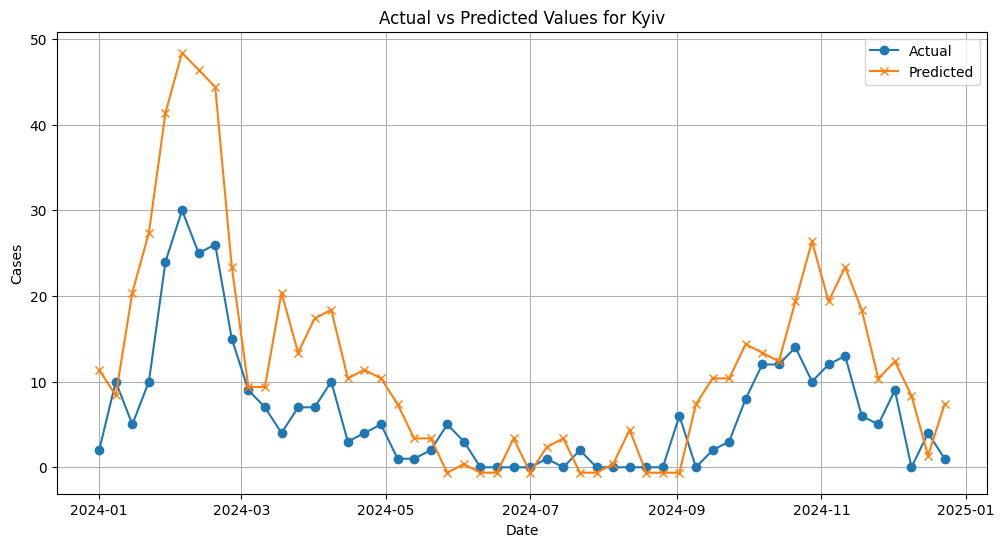

Region KyivCity Validation MAE: 2.95 Validation R²: 0.88
Region KyivCity Test MAE: 5.54 Test R²: -0.05
Region Luhansk Validation MAE: 5.79 Validation R²: -0.83
Region Luhansk Test MAE: 4.39 Test R²: -1.64
Region Lviv Validation MAE: 8.92 Validation R²: 0.32
Region Lviv Test MAE: 13.45 Test R²: -2.58


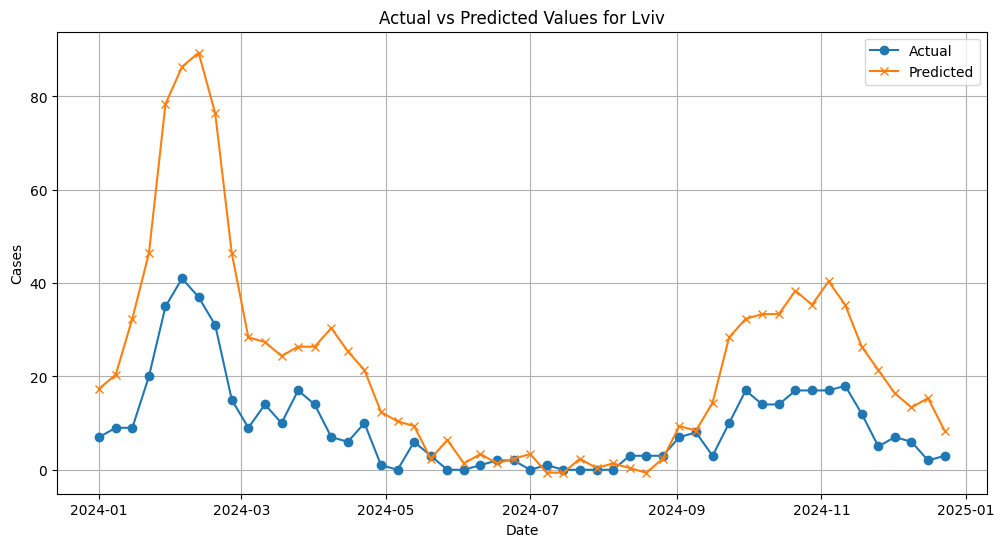

Region Mykolaiv Validation MAE: 2.92 Validation R²: 0.81
Region Mykolaiv Test MAE: 4.91 Test R²: -1.33


d:\University\Diploma\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Region Odessa Validation MAE: 7.74 Validation R²: 0.87
Region Odessa Test MAE: 19.08 Test R²: -1.01
Region Poltava Validation MAE: 5.61 Validation R²: -0.02
Region Poltava Test MAE: 8.59 Test R²: -8.38
Region Rivne Validation MAE: 3.59 Validation R²: 0.46
Region Rivne Test MAE: 5.48 Test R²: -3.46
Region Sumy Validation MAE: 2.84 Validation R²: 0.67
Region Sumy Test MAE: 4.08 Test R²: -2.69
Region Ternopil Validation MAE: 3.69 Validation R²: -1.31
Region Ternopil Test MAE: 4.27 Test R²: -5.87
Region Vinnytsia Validation MAE: 3.49 Validation R²: 0.57
Region Vinnytsia Test MAE: 5.79 Test R²: -2.23
Region Volyn Validation MAE: 4.82 Validation R²: 0.02
Region Volyn Test MAE: 6.23 Test R²: -2.96
Region Zakarpattia Validation MAE: 7.79 Validation R²: -0.34
Region Zakarpattia Test MAE: 11.19 Test R²: -5.44
Region Zaporizhzhia Validation MAE: 4.68 Validation R²: 0.74
Region Zaporizhzhia Test MAE: 3.58 Test R²: 0.58


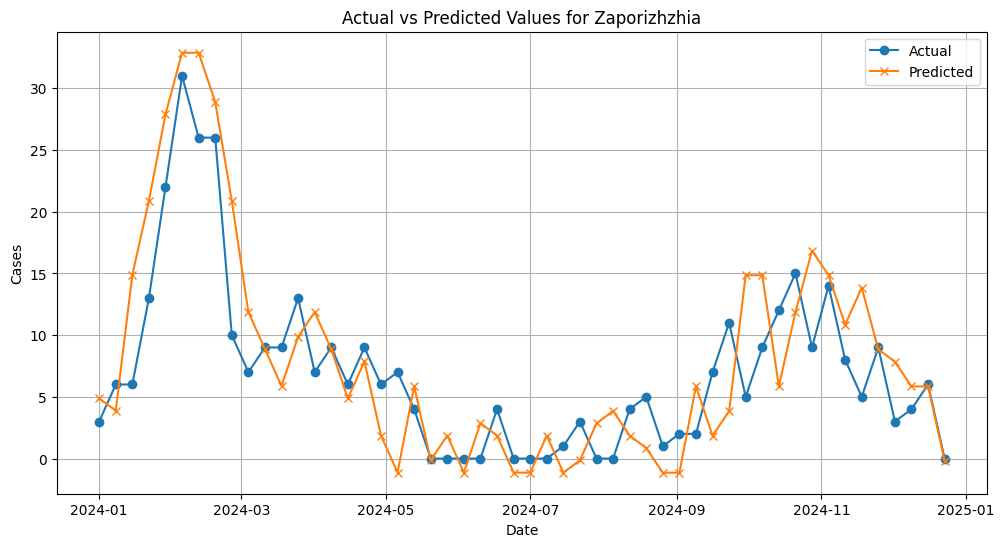

d:\University\Diploma\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Region Zhytomyr Validation MAE: 3.91 Validation R²: 0.46
Region Zhytomyr Test MAE: 6.62 Test R²: -1.79


In [ ]:
for region in data_by_region.keys():
    if region == 'AR Crimea':
        continue

    forecast_results, sarima_model, val_mae, val_r2, test_mae, test_r2 = \
        sarima_forecast(data_by_region[region], region, order=(0, 0, 0), seasonal_order=(0, 1, 0, 52), test_period=52, n_years_final_train=12)
    regions_mae_val[region] = val_mae
    regions_r2_val[region] = val_r2
    regions_mae_test[region] = test_mae
    regions_r2_test[region] = test_r2

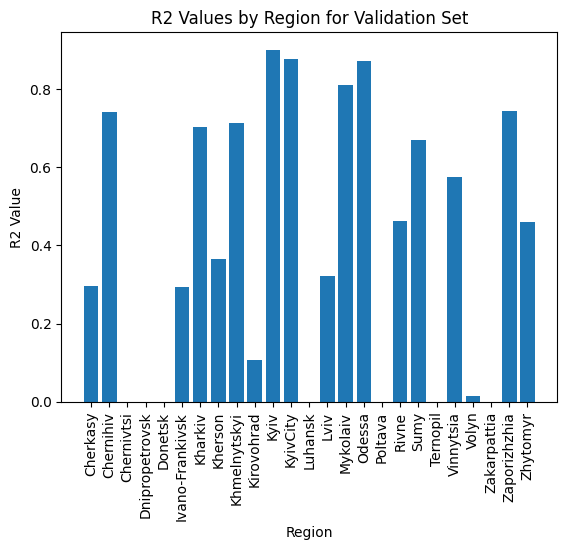

In [24]:
plt.bar(list(data_by_region.keys())[1:], np.array([regions_r2_val[region] for region in regions_r2_val.keys()]).clip(min=0))

plt.title('R2 Values by Region for Validation Set')
plt.xlabel('Region')
plt.ylabel('R2 Value')
plt.xticks(rotation=90)
plt.show()

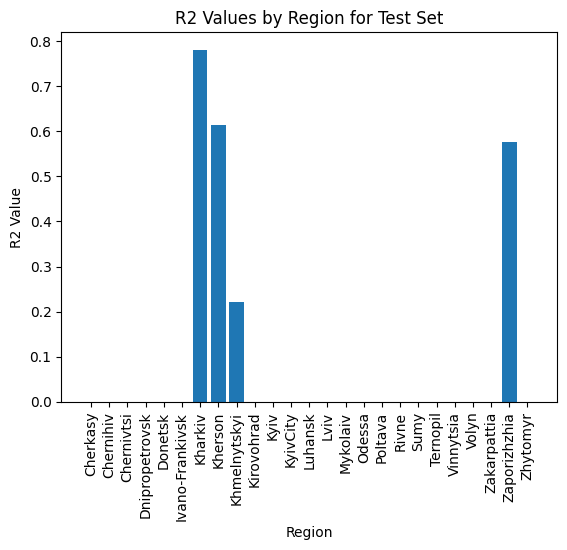

In [25]:
plt.bar(list(data_by_region.keys())[1:], np.array([regions_r2_test[region] for region in regions_r2_test.keys()]).clip(min=0))

plt.title('R2 Values by Region for Test Set')
plt.xlabel('Region')
plt.ylabel('R2 Value')
plt.xticks(rotation=90)
plt.show()

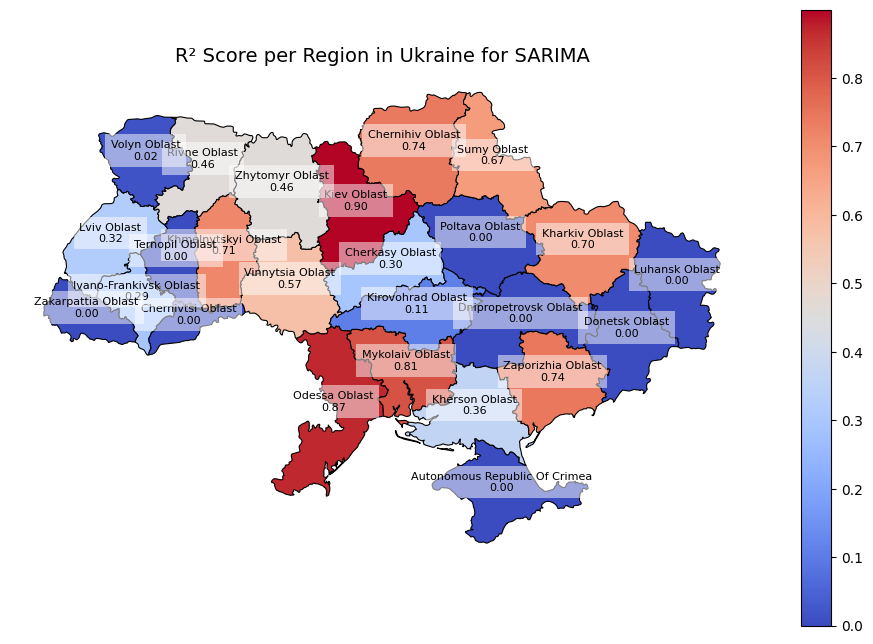

In [29]:
regions_to_r2 = {f"{region} Oblast": max(0, float(regions_r2_val[region])) for region in regions_r2_val.keys() if region != 'KyivCity'}
plot_ukraine_r2_heatmap('D:/University/Diploma/data/UA_FULL_Ukraine.geojson', regions_to_r2, algoithm_name='SARIMA')

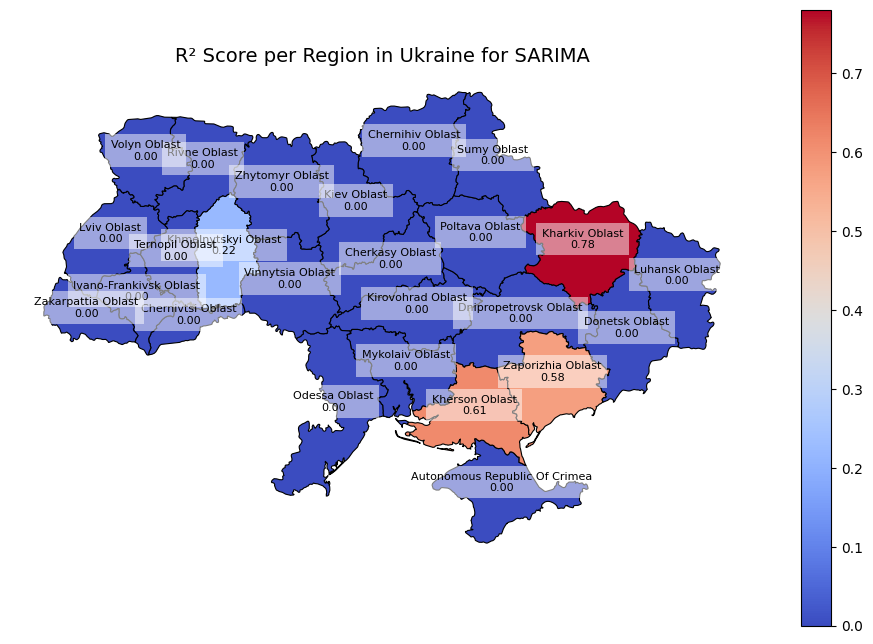

In [30]:
regions_to_r2 = {f"{region} Oblast": max(0, float(regions_r2_test[region])) for region in regions_r2_test.keys() if region != 'KyivCity'}
plot_ukraine_r2_heatmap('D:/University/Diploma/data/UA_FULL_Ukraine.geojson', regions_to_r2, algoithm_name='SARIMA')

# SARIMA more years validation

In [26]:
regions_r2 = {}
regions_mae = {}

Region Cherkasy Validation MAE: 3.42 Validation R²: 0.55
Region Chernihiv Validation MAE: 3.99 Validation R²: 0.20
Region Chernivtsi Validation MAE: 2.71 Validation R²: 0.15
Region Dnipropetrovsk Validation MAE: 15.87 Validation R²: 0.67
Region Donetsk Validation MAE: 8.37 Validation R²: 0.13
Region Ivano-Frankivsk Validation MAE: 3.25 Validation R²: 0.57


d:\University\Diploma\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Region Kharkiv Validation MAE: 5.75 Validation R²: 0.44
Region Kherson Validation MAE: 4.04 Validation R²: 0.41
Region Khmelnytskyi Validation MAE: 2.90 Validation R²: 0.62
Region Kirovohrad Validation MAE: 4.72 Validation R²: 0.48
Region Kyiv Validation MAE: 4.99 Validation R²: 0.54


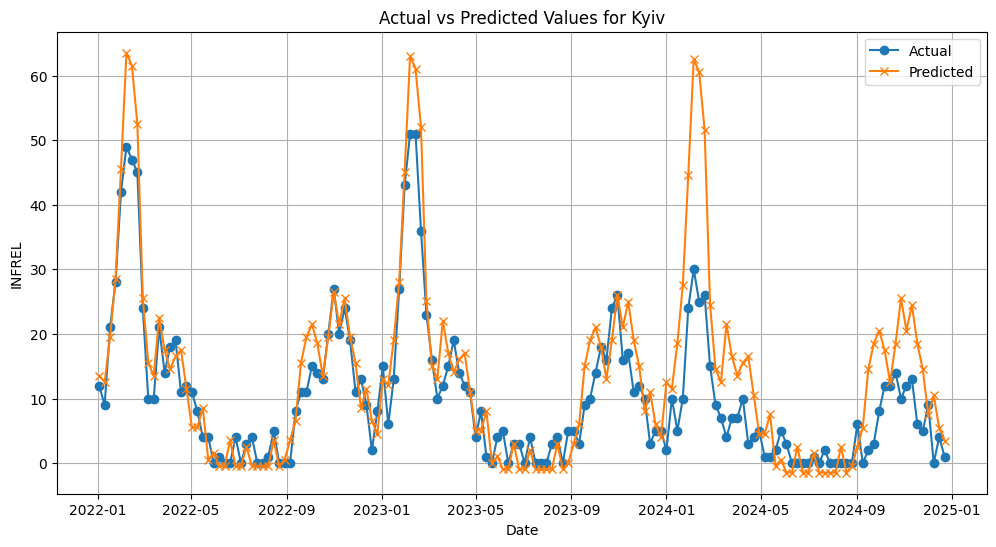

Region KyivCity Validation MAE: 4.28 Validation R²: 0.65
Region Luhansk Validation MAE: 4.38 Validation R²: -0.74
Region Lviv Validation MAE: 6.65 Validation R²: 0.69


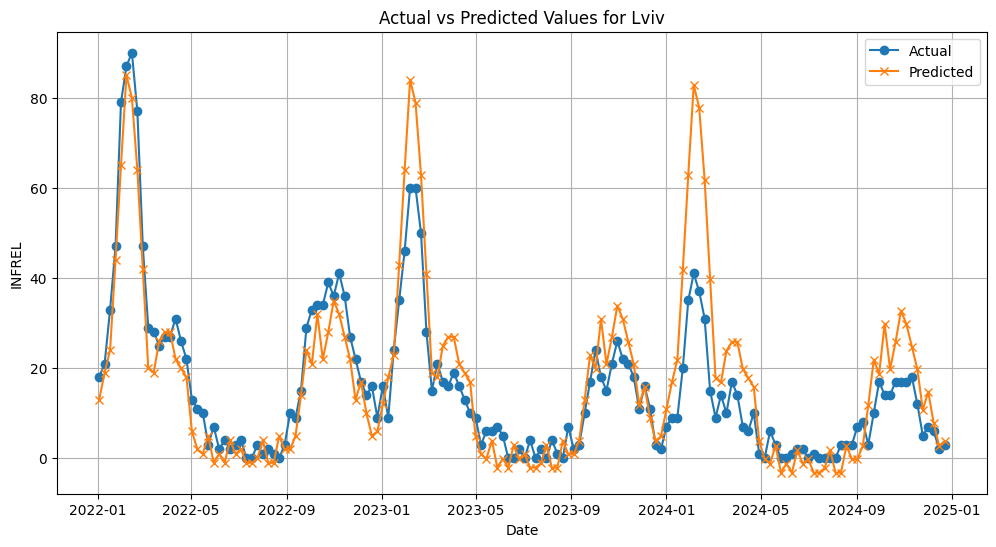

Region Mykolaiv Validation MAE: 3.62 Validation R²: 0.59
Region Odessa Validation MAE: 15.07 Validation R²: 0.39
Region Poltava Validation MAE: 4.22 Validation R²: 0.60
Region Rivne Validation MAE: 3.10 Validation R²: 0.56
Region Sumy Validation MAE: 3.14 Validation R²: 0.40
Region Ternopil Validation MAE: 3.30 Validation R²: 0.12


d:\University\Diploma\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Region Vinnytsia Validation MAE: 3.90 Validation R²: 0.57


d:\University\Diploma\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Region Volyn Validation MAE: 4.62 Validation R²: 0.29
Region Zakarpattia Validation MAE: 5.70 Validation R²: 0.54
Region Zaporizhzhia Validation MAE: 5.07 Validation R²: 0.43


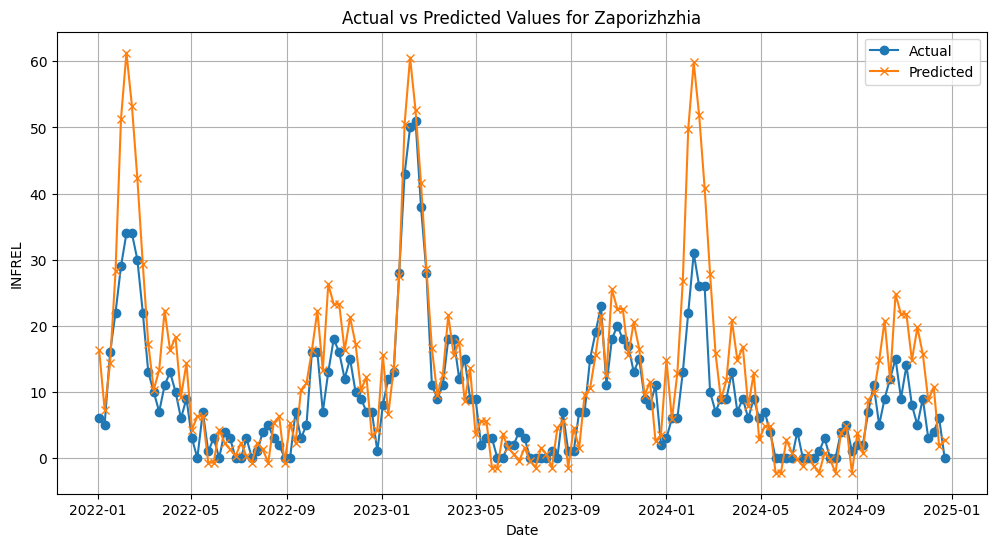

Region Zhytomyr Validation MAE: 4.04 Validation R²: 0.59


In [27]:
for region in data_by_region.keys():
    if region == 'AR Crimea':
        continue

    forecast_results, sarima_model, val_mae, val_r2 = sarima_forecast(data_by_region[region], region, order=(0, 0, 0), seasonal_order=(0, 1, 0, 52))
    regions_mae[region] = val_mae
    regions_r2[region] = val_r2

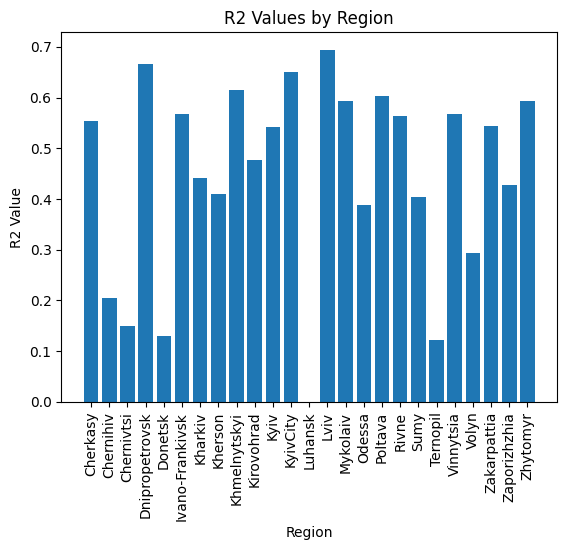

In [28]:
plt.bar(list(data_by_region.keys())[1:], np.array([regions_r2[region] for region in regions_r2.keys()]).clip(min=0))

plt.title('R2 Values by Region')
plt.xlabel('Region')
plt.ylabel('R2 Value')
plt.xticks(rotation=90)
plt.show()

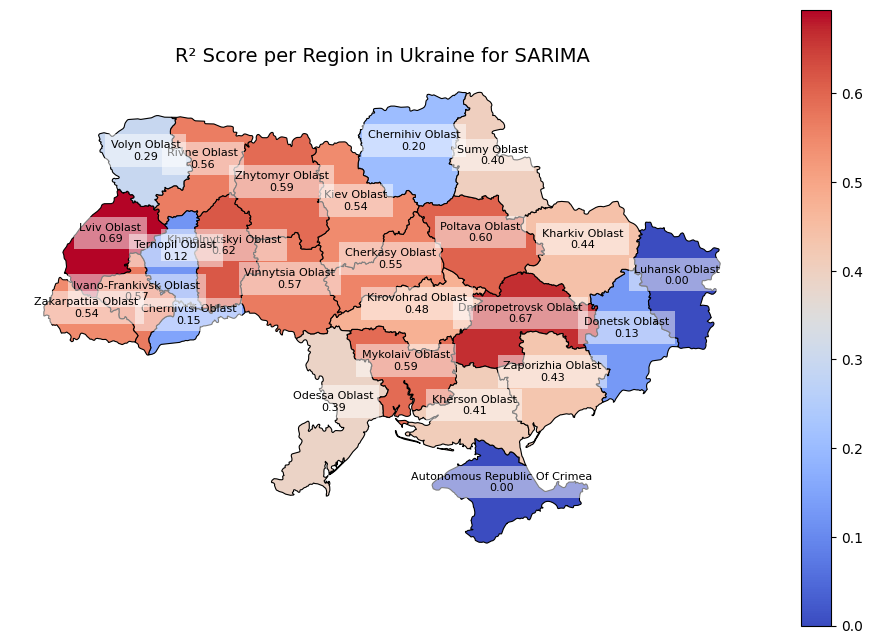

In [32]:
regions_to_r2 = {f"{region} Oblast": max(0, float(regions_r2[region])) for region in regions_r2.keys() if region != 'KyivCity'}
plot_ukraine_r2_heatmap('D:/University/Diploma/data/UA_FULL_Ukraine.geojson', regions_to_r2, algoithm_name="SARIMA")

# LSTM

In [ ]:
class LSTMForecast(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, predict_length=4, dropout=0.2):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers    
        self.predict_length = predict_length
        self.dropout = dropout
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            dropout=dropout,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, predict_length)

    def forward(self, x):
        """
        x: Tensor of shape (batch, seq_length, input_size)
        returns: Tensor of shape (batch, predict_length)
        """
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(x, (h0, c0))             
        last_hidden = lstm_out[:, -1, :]       
        output = self.fc(last_hidden)         
        return output

In [ ]:
def full_lstm_pipeline(data, seq_length, predict_length, n_splits, model_config, training_config, test_dates, region, n_years_final_train):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    val_final_input = data[-(2 * predict_length + seq_length):-predict_length]  
    val_final_target = data[-(2 * predict_length):-predict_length]              
    test_input = data[-(predict_length + seq_length): -predict_length]         
    test_target = data[-predict_length:]                                       

    data_train_val = data[:-(2 * predict_length)]  
    X_raw, y_raw = create_sequences(data_train_val, seq_length, predict_length)

    fold_metrics = {'train_loss': [], 'val_loss': []}
    splitter = AnchoredSequenceSplit(n_splits)

    best_model_state = None
    best_val_loss_overall = float('inf')

    if region in ['Zaporizhzhia', 'Lviv', 'Kyiv']:
        for fold, (train_idx, val_idx) in enumerate(tqdm(list(splitter.split(X_raw)), desc='Folds', leave=True)):
            X_train, y_train = X_raw[train_idx].astype(np.float32), y_raw[train_idx].astype(np.float32)
            X_val, y_val = X_raw[val_idx].astype(np.float32), y_raw[val_idx].astype(np.float32)

            for arr in [X_train, y_train, X_val, y_val]:
                arr[arr == 0] = 0.001

            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
            y_train_scaled = scaler.transform(y_train.reshape(-1, 1)).reshape(y_train.shape)
            X_val_scaled = scaler.transform(X_val.reshape(-1, 1)).reshape(X_val.shape)
            y_val_scaled = scaler.transform(y_val.reshape(-1, 1)).reshape(y_val.shape)

            train_ds = SequenceDataset(X_train_scaled, y_train_scaled)
            val_ds = SequenceDataset(X_val_scaled, y_val_scaled)
            train_dl = DataLoader(train_ds, batch_size=training_config['batch_size'], shuffle=False)
            val_dl = DataLoader(val_ds, batch_size=training_config['batch_size'])

            model = LSTMForecast(input_size=1, hidden_size=model_config['hidden_size'], num_layers=model_config['num_layers'], predict_length=predict_length, dropout=model_config['dropout']).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=training_config['lr'], weight_decay=training_config['weight_decay'])
            loss_fn = nn.L1Loss()

            train_losses, val_losses = [], []
            best_val_loss = float('inf')
            epochs_without_improvement = 0

            for epoch in range(training_config['epochs']):
                model.train()
                running_train_loss = 0
                for xb, yb in train_dl:
                    xb, yb = xb.to(device), yb.to(device)
                    optimizer.zero_grad()
                    preds = model(xb)
                    loss = loss_fn(preds, yb)
                    loss.backward()
                    optimizer.step()
                    running_train_loss += loss.item() * xb.size(0)
                train_loss = running_train_loss / len(train_dl.dataset)

                model.eval()
                running_val_loss = 0
                with torch.no_grad():
                    for xb, yb in val_dl:
                        xb, yb = xb.to(device), yb.to(device)
                        preds = model(xb)
                        loss = loss_fn(preds, yb)
                        running_val_loss += loss.item() * xb.size(0)
                val_loss = running_val_loss / len(val_dl.dataset)

                train_losses.append(train_loss)
                val_losses.append(val_loss)

                if (epoch+1) % 5 == 0 and region in ['Zaporizhzhia', 'Lviv', 'Kyiv']:
                    print(f"Fold {fold+1}/{n_splits} - Epoch {epoch+1}/{training_config['epochs']} - "
                        f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    if best_val_loss < best_val_loss_overall:
                        best_val_loss_overall = best_val_loss
                        best_model_state = model.state_dict()
                    epochs_without_improvement = 0
                else:
                    epochs_without_improvement += 1
                    if epochs_without_improvement >= training_config['patience']:
                        break

            fold_metrics['train_loss'].append(train_losses)
            fold_metrics['val_loss'].append(val_losses)
        
        
        plt.figure(figsize=(12, 5))
        for fold in range(n_splits):
            plt.plot(fold_metrics['train_loss'][fold], label=f'Train Fold {fold+1}')
        plt.title('Training Loss per Fold')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(12, 5))
        for fold in range(n_splits):
            plt.plot(fold_metrics['val_loss'][fold], label=f'Val Fold {fold+1}')
        plt.title('Validation Loss per Fold')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()

        print("\nWalk-forward validation complete. Retraining model on full training data for final evaluation...")

    weeks_per_year = 52
    n_final_samples = n_years_final_train * weeks_per_year
    data_final_train = data_train_val[-n_final_samples:]
    X_all, y_all = create_sequences(data_final_train, seq_length, predict_length)
    X_all[X_all == 0] = 0.001
    y_all[y_all == 0] = 0.001

    scaler = StandardScaler()
    X_all_scaled = scaler.fit_transform(X_all.reshape(-1, 1)).reshape(X_all.shape)
    y_all_scaled = scaler.transform(y_all.reshape(-1, 1)).reshape(y_all.shape)

    final_train_ds = SequenceDataset(X_all_scaled, y_all_scaled)
    final_train_dl = DataLoader(final_train_ds, batch_size=training_config['batch_size'], shuffle=False)

    final_model = LSTMForecast(
        input_size=1,
        hidden_size=model_config['hidden_size'],
        num_layers=model_config['num_layers'],
        predict_length=predict_length,
        dropout=model_config['dropout']
    ).to(device)

    optimizer = torch.optim.Adam(final_model.parameters(), lr=training_config['lr'], weight_decay=training_config['weight_decay'])
    loss_fn = nn.L1Loss()

    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(training_config['epochs']):
        final_model.train()
        running_loss = 0
        for xb, yb in final_train_dl:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = final_model(xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)
        avg_loss = running_loss / len(final_train_dl.dataset)

        if (epoch+1) % 5 == 0 and region in ['Zaporizhzhia', 'Lviv', 'Kyiv']:
            print(f"Retrain Epoch {epoch+1}/{training_config['epochs']} - Loss: {avg_loss:.4f}")

        if avg_loss < best_val_loss:
            best_val_loss = avg_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= training_config['patience']:
                break

    model = final_model
    model.eval()

    val_metrics = {}
    test_metrics = {}

    for label, raw_input, raw_target in [("Validation", val_final_input, val_final_target), ("Test", test_input, test_target)]:
        raw_input[raw_input == 0] = 0.001
        raw_target[raw_target == 0] = 0.001
        scaled_input = scaler.transform(raw_input[-seq_length:].reshape(-1, 1)).reshape(1, seq_length, 1)

        with torch.no_grad():
            input_tensor = torch.tensor(scaled_input, dtype=torch.float32).to(device)
            pred_scaled = model(input_tensor).cpu().numpy()
        pred_final = scaler.inverse_transform(pred_scaled).flatten()

        pred_final = np.clip(pred_final, a_min=0, a_max=None)
        target_final = raw_target.flatten()

        mae = mean_absolute_error(target_final, pred_final)
        r2 = r2_score(target_final, pred_final)

        if label == "Validation":
            val_metrics = {"mae": mae, "r2": r2}
        elif label == "Test":
            test_metrics = {"mae": mae, "r2": r2}

        if region in ['Zaporizhzhia', 'Lviv', 'Kyiv']:
            plt.figure(figsize=(12, 5))
            plt.plot(test_dates, target_final, label=f'Actual {label}', marker='o')
            plt.plot(test_dates, pred_final, label=f'Predicted {label}', marker='x')
            plt.title(f'{label} Set: Predicted vs Actual')
            plt.xlabel('Date')
            plt.ylabel('Cases')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        print(f"\nFinal {label} MAE: {mae:.4f} for {region}")
        print(f"Final {label} R²: {r2:.4f} for {region}")

    return val_metrics, test_metrics

In [27]:
regions_mae_val = {}
regions_r2_val = {}

regions_mae_test = {}
regions_r2_test = {}

Using device: cuda

Final Validation MAE: 2.5080 for Cherkasy
Final Validation R²: 0.8310 for Cherkasy

Final Test MAE: 2.9020 for Cherkasy
Final Test R²: 0.4770 for Cherkasy
Using device: cuda

Final Validation MAE: 2.7020 for Chernihiv
Final Validation R²: 0.6940 for Chernihiv

Final Test MAE: 3.1090 for Chernihiv
Final Test R²: 0.3370 for Chernihiv
Using device: cuda

Final Validation MAE: 2.6160 for Chernivtsi
Final Validation R²: 0.6830 for Chernivtsi

Final Test MAE: 2.9820 for Chernivtsi
Final Test R²: 0.4140 for Chernivtsi
Using device: cuda

Final Validation MAE: 4.9730 for Dnipropetrovsk
Final Validation R²: 0.8630 for Dnipropetrovsk

Final Test MAE: 5.7960 for Dnipropetrovsk
Final Test R²: 0.6100 for Dnipropetrovsk
Using device: cuda

Final Validation MAE: 9.2490 for Donetsk
Final Validation R²: 0.5920 for Donetsk

Final Test MAE: 10.6760 for Donetsk
Final Test R²: 0.3670 for Donetsk
Using device: cuda

Final Validation MAE: 2.7690 for Ivano-Frankivsk
Final Validation R²: 0.

Folds:   0%|          | 0/3 [00:00<?, ?it/s]

Fold 1/3 - Epoch 5/85 - Train Loss: 0.5728, Val Loss: 0.6129
Fold 1/3 - Epoch 10/85 - Train Loss: 0.4061, Val Loss: 0.4190
Fold 1/3 - Epoch 15/85 - Train Loss: 0.3197, Val Loss: 0.4337
Fold 1/3 - Epoch 20/85 - Train Loss: 0.2718, Val Loss: 0.3085
Fold 1/3 - Epoch 25/85 - Train Loss: 0.2675, Val Loss: 0.3272
Fold 1/3 - Epoch 30/85 - Train Loss: 0.2306, Val Loss: 0.2839
Fold 1/3 - Epoch 35/85 - Train Loss: 0.2268, Val Loss: 0.2792
Fold 1/3 - Epoch 40/85 - Train Loss: 0.2423, Val Loss: 0.3482


Folds:  33%|███▎      | 1/3 [00:18<00:37, 18.81s/it]

Fold 2/3 - Epoch 5/85 - Train Loss: 0.5377, Val Loss: 0.8468
Fold 2/3 - Epoch 10/85 - Train Loss: 0.3797, Val Loss: 0.6291
Fold 2/3 - Epoch 15/85 - Train Loss: 0.3358, Val Loss: 0.5093
Fold 2/3 - Epoch 20/85 - Train Loss: 0.2990, Val Loss: 0.4524
Fold 2/3 - Epoch 25/85 - Train Loss: 0.2947, Val Loss: 0.5019
Fold 2/3 - Epoch 30/85 - Train Loss: 0.2737, Val Loss: 0.4652
Fold 2/3 - Epoch 35/85 - Train Loss: 0.3213, Val Loss: 0.4967
Fold 2/3 - Epoch 40/85 - Train Loss: 0.2668, Val Loss: 0.4545


Folds:  67%|██████▋   | 2/3 [00:49<00:26, 26.05s/it]

Fold 3/3 - Epoch 5/85 - Train Loss: 0.5387, Val Loss: 0.5523
Fold 3/3 - Epoch 10/85 - Train Loss: 0.3999, Val Loss: 0.4399
Fold 3/3 - Epoch 15/85 - Train Loss: 0.3687, Val Loss: 0.3311
Fold 3/3 - Epoch 20/85 - Train Loss: 0.2599, Val Loss: 0.3264
Fold 3/3 - Epoch 25/85 - Train Loss: 0.2604, Val Loss: 0.2854
Fold 3/3 - Epoch 30/85 - Train Loss: 0.3074, Val Loss: 0.2866


Folds: 100%|██████████| 3/3 [01:17<00:00, 25.99s/it]


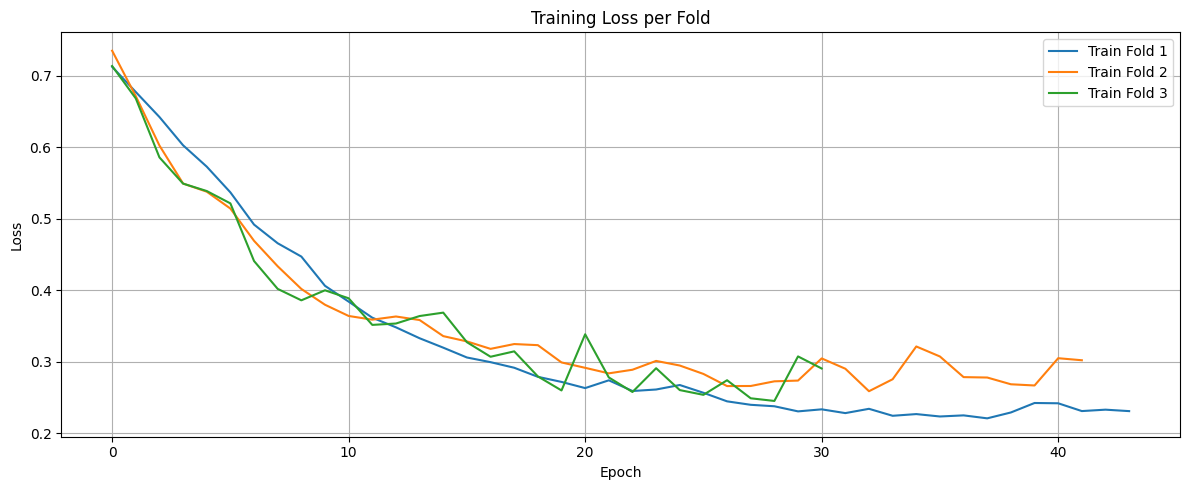

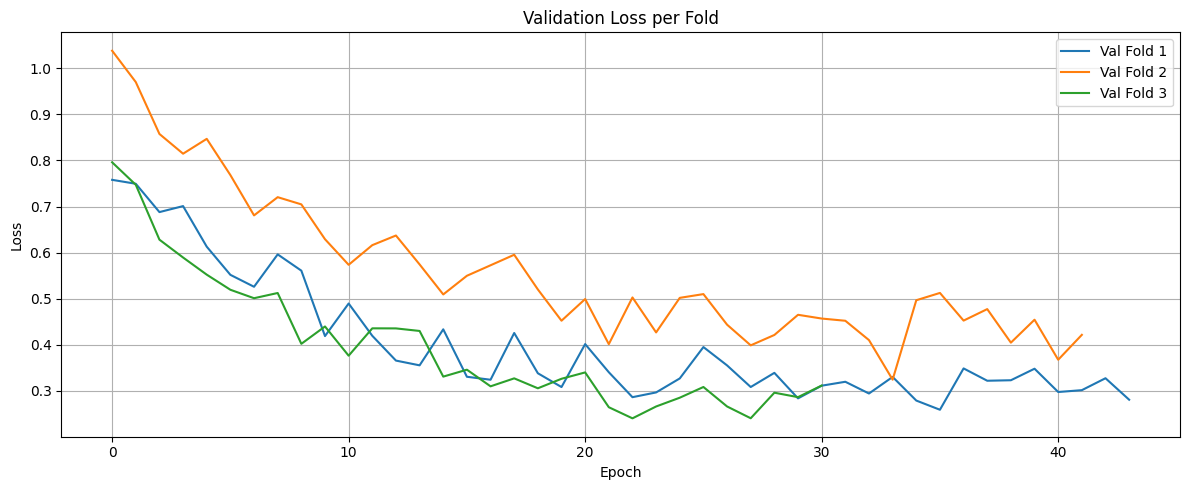


Walk-forward validation complete. Retraining model on full training data for final evaluation...
Retrain Epoch 5/85 - Loss: 0.2435
Retrain Epoch 10/85 - Loss: 0.1837
Retrain Epoch 15/85 - Loss: 0.1717
Retrain Epoch 20/85 - Loss: 0.1620
Retrain Epoch 25/85 - Loss: 0.1556
Retrain Epoch 30/85 - Loss: 0.1562
Retrain Epoch 35/85 - Loss: 0.1546
Retrain Epoch 40/85 - Loss: 0.1536
Retrain Epoch 45/85 - Loss: 0.1499
Retrain Epoch 50/85 - Loss: 0.1485
Retrain Epoch 55/85 - Loss: 0.1478
Retrain Epoch 60/85 - Loss: 0.1485


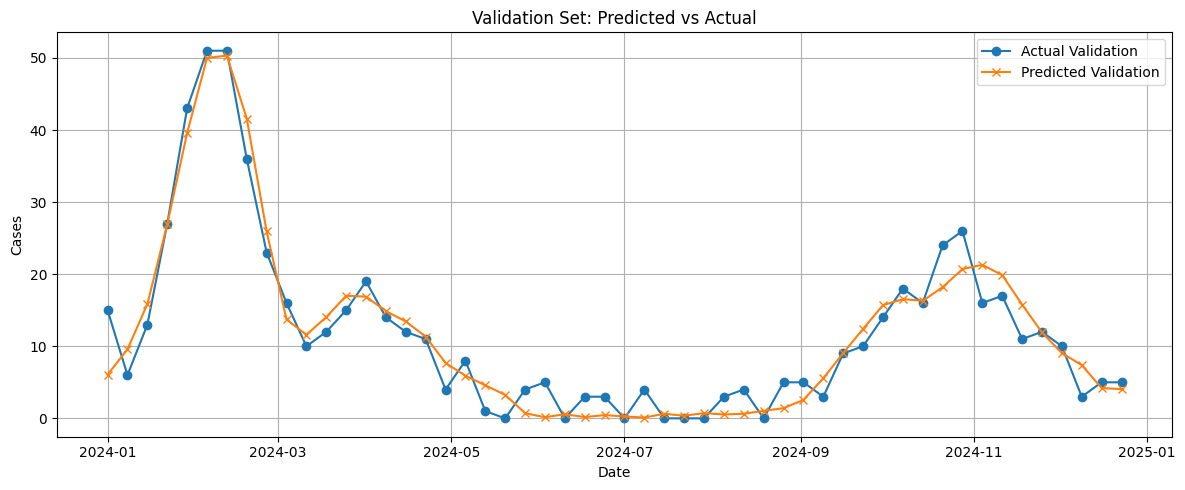


Final Validation MAE: 2.4408 for Kyiv
Final Validation R²: 0.9363 for Kyiv


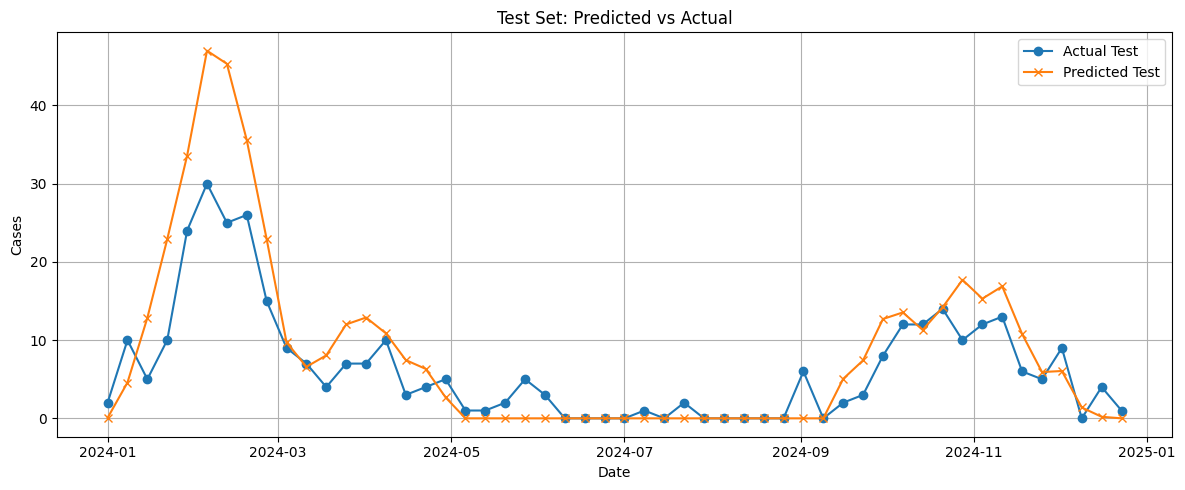


Final Test MAE: 3.5351 for Kyiv
Final Test R²: 0.4080 for Kyiv
Using device: cuda

Final Validation MAE: 3.5500 for KyivCity
Final Validation R²: 0.7100 for KyivCity

Final Test MAE: 4.1330 for KyivCity
Final Test R²: 0.8910 for KyivCity
Using device: cuda

Final Validation MAE: 4.0660 for Luhansk
Final Validation R²: 0.6470 for Luhansk

Final Test MAE: 4.7280 for Luhansk
Final Test R²: 0.4630 for Luhansk
Using device: cuda


Folds:   0%|          | 0/3 [00:00<?, ?it/s]

Fold 1/3 - Epoch 5/85 - Train Loss: 0.5529, Val Loss: 0.5768
Fold 1/3 - Epoch 10/85 - Train Loss: 0.4132, Val Loss: 0.4956
Fold 1/3 - Epoch 15/85 - Train Loss: 0.3485, Val Loss: 0.3868
Fold 1/3 - Epoch 20/85 - Train Loss: 0.2759, Val Loss: 0.3939
Fold 1/3 - Epoch 25/85 - Train Loss: 0.2369, Val Loss: 0.3021
Fold 1/3 - Epoch 30/85 - Train Loss: 0.2202, Val Loss: 0.2668
Fold 1/3 - Epoch 35/85 - Train Loss: 0.1986, Val Loss: 0.3293
Fold 1/3 - Epoch 40/85 - Train Loss: 0.2147, Val Loss: 0.2864


Folds:  33%|███▎      | 1/3 [00:14<00:29, 14.85s/it]

Fold 2/3 - Epoch 5/85 - Train Loss: 0.5111, Val Loss: 0.8486
Fold 2/3 - Epoch 10/85 - Train Loss: 0.3508, Val Loss: 0.6124
Fold 2/3 - Epoch 15/85 - Train Loss: 0.3217, Val Loss: 0.5510
Fold 2/3 - Epoch 20/85 - Train Loss: 0.3076, Val Loss: 0.4855
Fold 2/3 - Epoch 25/85 - Train Loss: 0.2902, Val Loss: 0.5418
Fold 2/3 - Epoch 30/85 - Train Loss: 0.2260, Val Loss: 0.3814
Fold 2/3 - Epoch 35/85 - Train Loss: 0.2376, Val Loss: 0.3403


Folds:  67%|██████▋   | 2/3 [00:43<00:22, 22.73s/it]

Fold 2/3 - Epoch 40/85 - Train Loss: 0.2075, Val Loss: 0.3924
Fold 3/3 - Epoch 5/85 - Train Loss: 0.5242, Val Loss: 0.5076
Fold 3/3 - Epoch 10/85 - Train Loss: 0.3698, Val Loss: 0.3476
Fold 3/3 - Epoch 15/85 - Train Loss: 0.3340, Val Loss: 0.3122


Folds: 100%|██████████| 3/3 [01:01<00:00, 20.57s/it]

Fold 3/3 - Epoch 20/85 - Train Loss: 0.3073, Val Loss: 0.3353


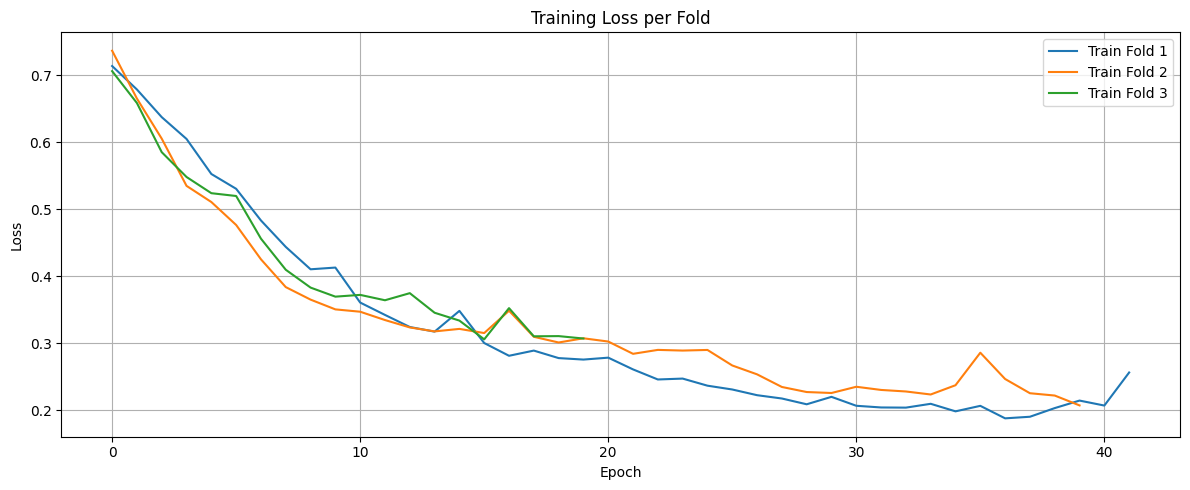

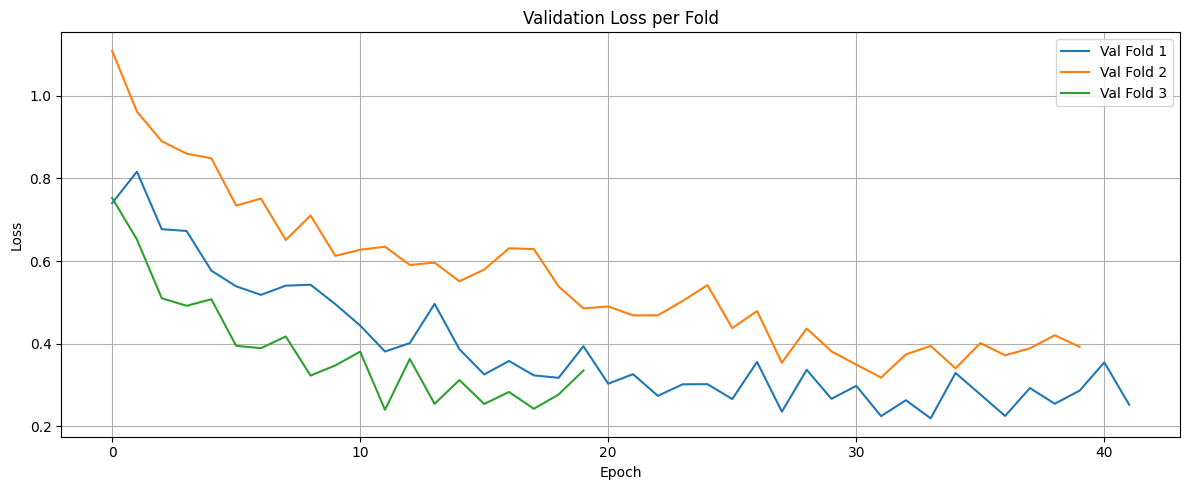


Walk-forward validation complete. Retraining model on full training data for final evaluation...
Retrain Epoch 5/85 - Loss: 0.2154
Retrain Epoch 10/85 - Loss: 0.1507
Retrain Epoch 15/85 - Loss: 0.1385
Retrain Epoch 20/85 - Loss: 0.1404
Retrain Epoch 25/85 - Loss: 0.1265
Retrain Epoch 30/85 - Loss: 0.1256
Retrain Epoch 35/85 - Loss: 0.1271
Retrain Epoch 40/85 - Loss: 0.1206
Retrain Epoch 45/85 - Loss: 0.1246
Retrain Epoch 50/85 - Loss: 0.1286
Retrain Epoch 55/85 - Loss: 0.1186
Retrain Epoch 60/85 - Loss: 0.1165


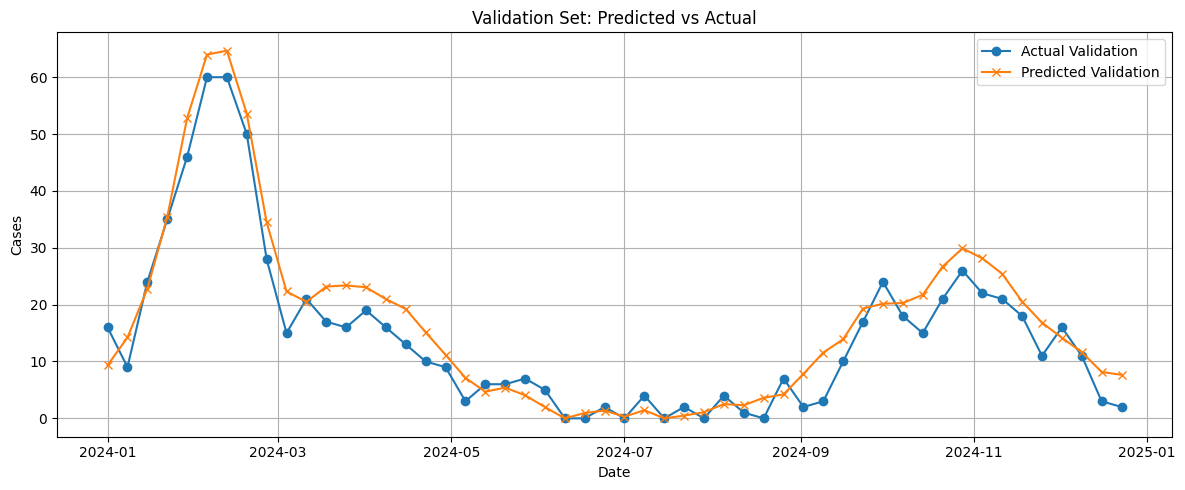


Final Validation MAE: 3.5850 for Lviv
Final Validation R²: 0.9120 for Lviv


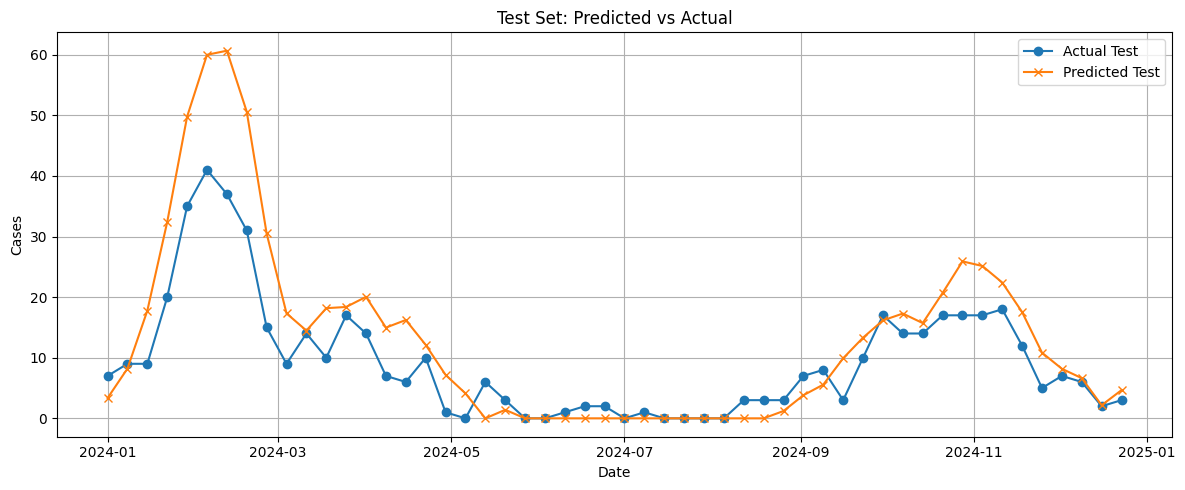


Final Test MAE: 4.9306 for Lviv
Final Test R²: 0.4237 for Lviv
Using device: cuda

Final Validation MAE: 2.9670 for Mykolaiv
Final Validation R²: 0.8930 for Mykolaiv

Final Test MAE: 3.5520 for Mykolaiv
Final Test R²: 0.7030 for Mykolaiv
Using device: cuda

Final Validation MAE: 4.1040 for Odessa
Final Validation R²: 0.8650 for Odessa

Final Test MAE: 4.8760 for Odessa
Final Test R²: 0.4690 for Odessa
Using device: cuda

Final Validation MAE: 2.7190 for Poltava
Final Validation R²: 0.4390 for Poltava

Final Test MAE: 3.1280 for Poltava
Final Test R²: 0.4530 for Poltava
Using device: cuda

Final Validation MAE: 2.8810 for Rivne
Final Validation R²: 0.4950 for Rivne

Final Test MAE: 3.3420 for Rivne
Final Test R²: 0.3790 for Rivne
Using device: cuda

Final Validation MAE: 2.3950 for Sumy
Final Validation R²: 0.7990 for Sumy

Final Test MAE: 2.7510 for Sumy
Final Test R²: 0.4760 for Sumy
Using device: cuda

Final Validation MAE: 1.9440 for Ternopil
Final Validation R²: 0.5430 for Ternopi

Folds:   0%|          | 0/3 [00:00<?, ?it/s]

Fold 1/3 - Epoch 5/85 - Train Loss: 0.5578, Val Loss: 0.6410
Fold 1/3 - Epoch 10/85 - Train Loss: 0.4089, Val Loss: 0.4265
Fold 1/3 - Epoch 15/85 - Train Loss: 0.3413, Val Loss: 0.4231
Fold 1/3 - Epoch 20/85 - Train Loss: 0.2951, Val Loss: 0.3400
Fold 1/3 - Epoch 25/85 - Train Loss: 0.2654, Val Loss: 0.3685
Fold 1/3 - Epoch 30/85 - Train Loss: 0.2583, Val Loss: 0.2549
Fold 1/3 - Epoch 35/85 - Train Loss: 0.2336, Val Loss: 0.3766


Folds:  33%|███▎      | 1/3 [00:16<00:33, 16.69s/it]

Fold 2/3 - Epoch 5/85 - Train Loss: 0.5244, Val Loss: 0.7626
Fold 2/3 - Epoch 10/85 - Train Loss: 0.3893, Val Loss: 0.6116
Fold 2/3 - Epoch 15/85 - Train Loss: 0.3359, Val Loss: 0.5070
Fold 2/3 - Epoch 20/85 - Train Loss: 0.3022, Val Loss: 0.5127
Fold 2/3 - Epoch 25/85 - Train Loss: 0.2813, Val Loss: 0.4352
Fold 2/3 - Epoch 30/85 - Train Loss: 0.2451, Val Loss: 0.3635
Fold 2/3 - Epoch 35/85 - Train Loss: 0.2874, Val Loss: 0.4618


Folds:  67%|██████▋   | 2/3 [00:39<00:20, 20.26s/it]

Fold 3/3 - Epoch 5/85 - Train Loss: 0.5362, Val Loss: 0.5612
Fold 3/3 - Epoch 10/85 - Train Loss: 0.3739, Val Loss: 0.3471
Fold 3/3 - Epoch 15/85 - Train Loss: 0.3381, Val Loss: 0.3802
Fold 3/3 - Epoch 20/85 - Train Loss: 0.3552, Val Loss: 0.1927
Fold 3/3 - Epoch 25/85 - Train Loss: 0.2708, Val Loss: 0.1595
Fold 3/3 - Epoch 30/85 - Train Loss: 0.2247, Val Loss: 0.2252
Fold 3/3 - Epoch 35/85 - Train Loss: 0.2817, Val Loss: 0.1295


Folds: 100%|██████████| 3/3 [01:14<00:00, 24.98s/it]


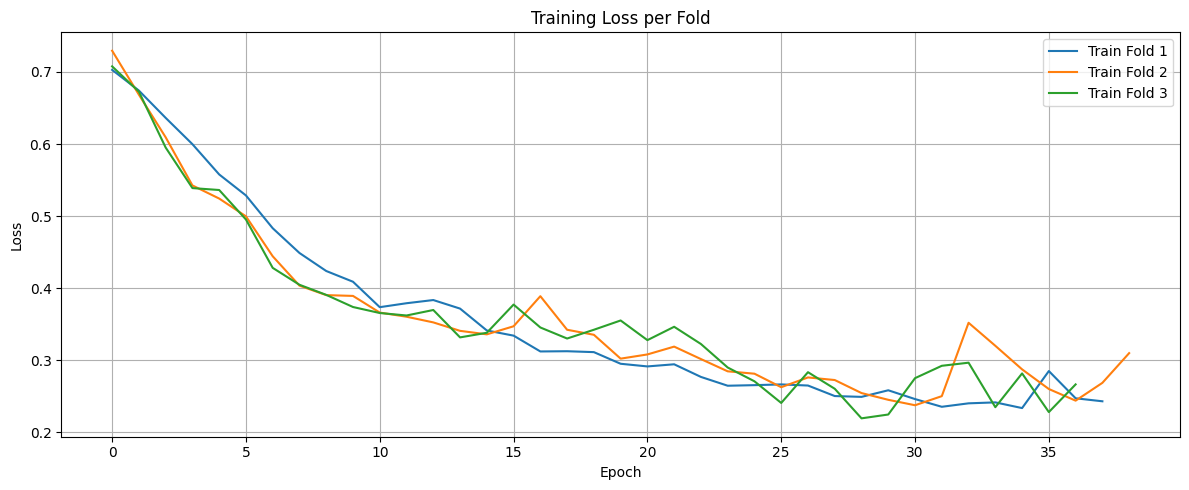

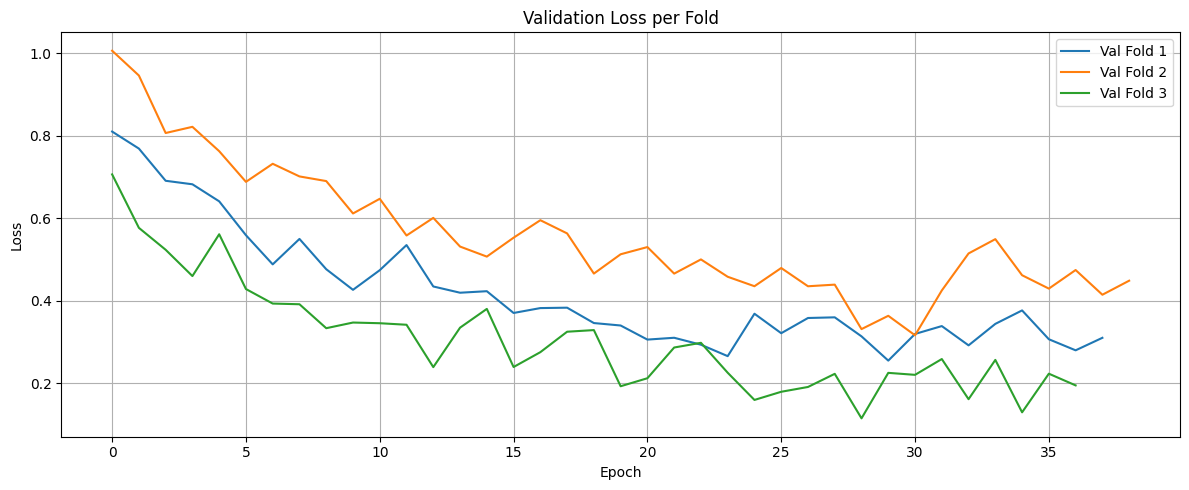


Walk-forward validation complete. Retraining model on full training data for final evaluation...
Retrain Epoch 5/85 - Loss: 0.2418
Retrain Epoch 10/85 - Loss: 0.1746
Retrain Epoch 15/85 - Loss: 0.1606
Retrain Epoch 20/85 - Loss: 0.1563
Retrain Epoch 25/85 - Loss: 0.1488
Retrain Epoch 30/85 - Loss: 0.1445
Retrain Epoch 35/85 - Loss: 0.1450
Retrain Epoch 40/85 - Loss: 0.1518
Retrain Epoch 45/85 - Loss: 0.1442


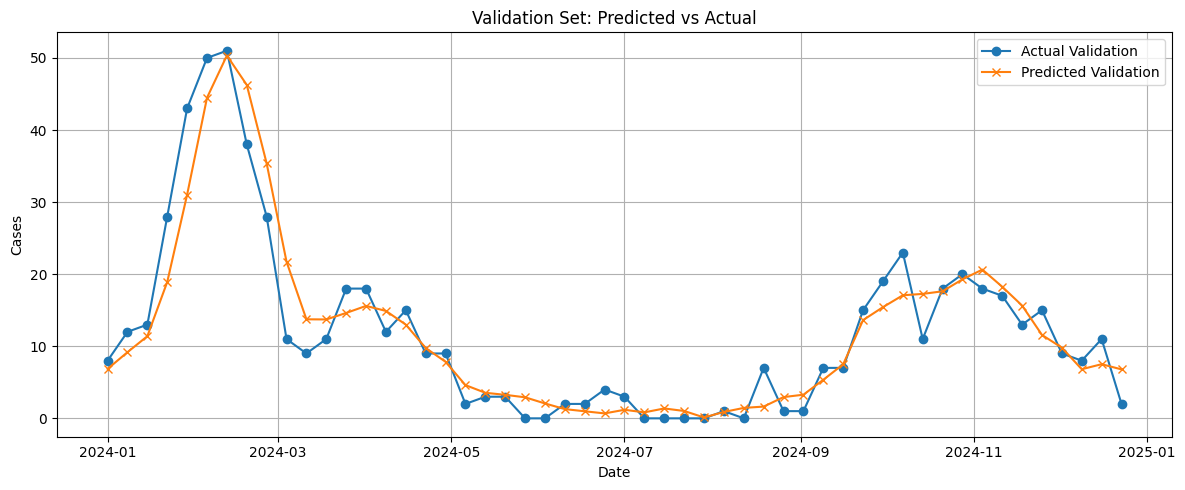


Final Validation MAE: 2.8777 for Zaporizhzhia
Final Validation R²: 0.8965 for Zaporizhzhia


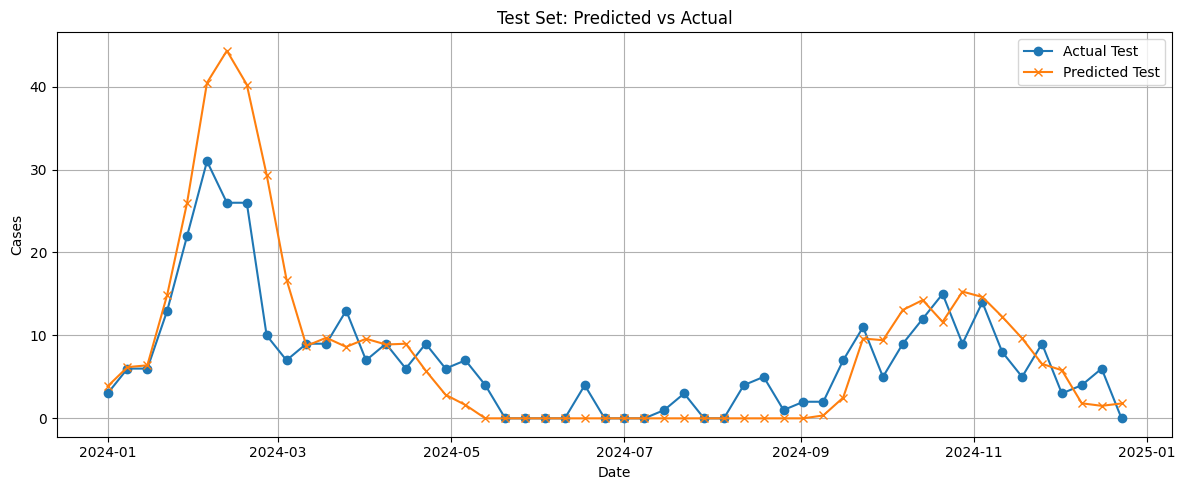


Final Test MAE: 3.3956 for Zaporizhzhia
Final Test R²: 0.4031 for Zaporizhzhia
Using device: cuda

Final Validation MAE: 3.1510 for Zhytomyr
Final Validation R²: 0.7510 for Zhytomyr

Final Test MAE: 3.7190 for Zhytomyr
Final Test R²: 0.5350 for Zhytomyr


In [ ]:
seq_length = 52
predict_length = 52
n_splits = 3
model_config = {
    'hidden_size': 200,
    'num_layers': 3,
    'dropout': 0.35
}
training_config = {
    'batch_size': 64,
    'lr': 0.001,
    'epochs': 85,
    'patience': 8,
    'weight_decay': 0.0001
}

for region in data_by_region.keys():
    if region == 'AR Crimea':
        continue

    region_data = data_by_region[region]['INFREL'].values


    lstm_val_history, lstm_test_history = full_lstm_pipeline(region_data, seq_length, 
                    predict_length, n_splits, 
                    model_config, training_config, 
                    data_by_region[region]['DATE'][-predict_length:].values, 
                    region,
                    12)
    
    regions_mae_val[region] = lstm_val_history['mae']
    regions_r2_val[region] = lstm_val_history['r2']

    regions_mae_test[region] = lstm_test_history['mae']
    regions_r2_test[region] = lstm_test_history['r2']

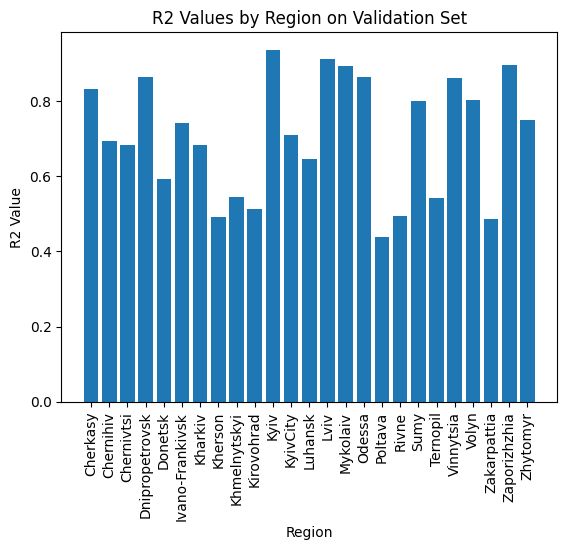

In [29]:
plt.bar(list(data_by_region.keys())[1:], np.array([regions_r2_val[region] for region in regions_r2_val.keys()]).clip(min=0))

plt.title('R2 Values by Region on Validation Set')
plt.xlabel('Region')
plt.ylabel('R2 Value')
plt.xticks(rotation=90)
plt.show()

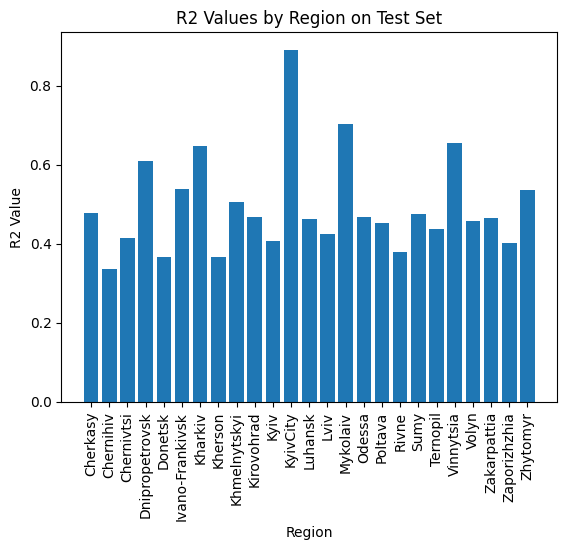

In [30]:
plt.bar(list(data_by_region.keys())[1:], np.array([regions_r2_test[region] for region in regions_r2_test.keys()]).clip(min=0))

plt.title('R2 Values by Region on Test Set')
plt.xlabel('Region')
plt.ylabel('R2 Value')
plt.xticks(rotation=90)
plt.show()

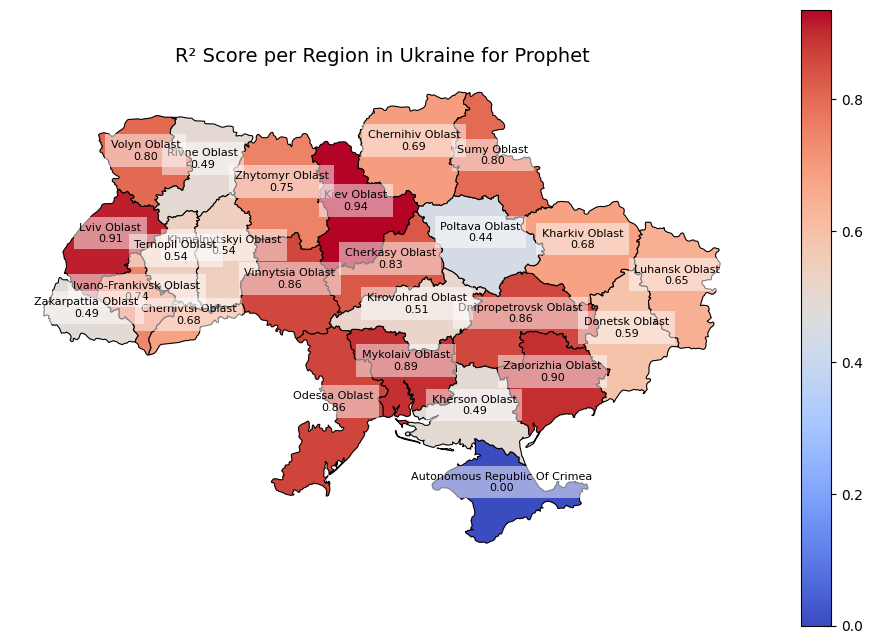

In [31]:
regions_to_r2_val = {f'{region} Oblast': max(0, float(regions_r2_val[region])) for region in regions_r2_val.keys() if region != 'KyivCity'}
plot_ukraine_r2_heatmap('D:/University/Diploma/data/UA_FULL_Ukraine.geojson', regions_to_r2_val)

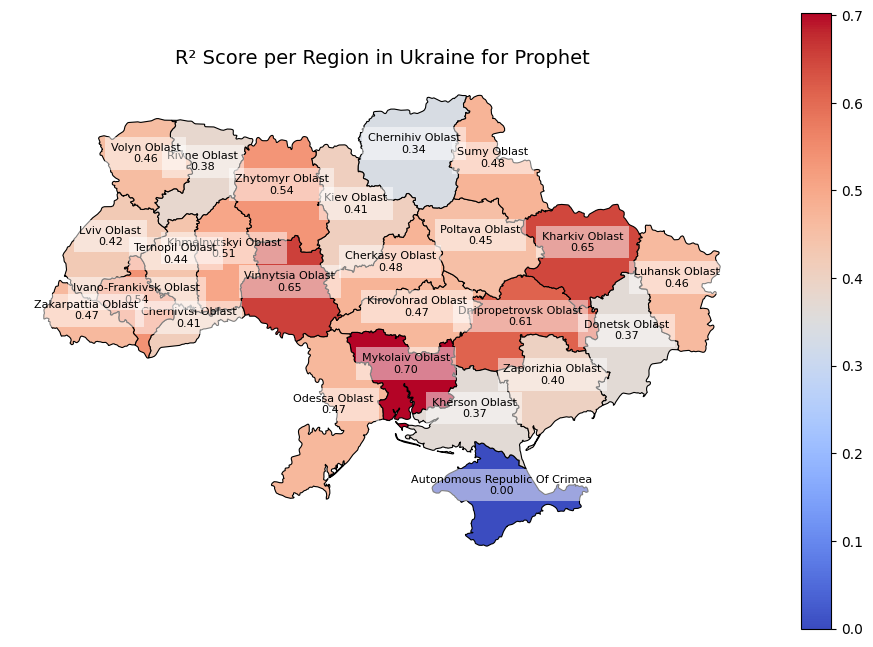

In [32]:
regions_to_r2_test = {f'{region} Oblast': max(0, float(regions_r2_test[region])) for region in regions_r2_test.keys() if region != 'KyivCity'}
plot_ukraine_r2_heatmap('D:/University/Diploma/data/UA_FULL_Ukraine.geojson', regions_to_r2_test)

# GRU

In [ ]:
class GRUForecast(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, predict_length=4, dropout=0.2):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers    
        self.predict_length = predict_length
        self.dropout = dropout
        self.gru = nn.GRU(input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          dropout=dropout,
                          batch_first=True)
        self.fc = nn.Linear(hidden_size, predict_length)

    def forward(self, x):
        """
        x: Tensor of shape (batch, seq_length, input_size)
        returns: Tensor of shape (batch, predict_length)
        """
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        gru_out, _ = self.gru(x, h0)             
        last_hidden = gru_out[:, -1, :]       
        output = self.fc(last_hidden)         
        return output

In [ ]:
def full_gru_pipeline(data, seq_length, predict_length, n_splits, model_config, training_config, test_dates, region, n_years_final_train):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    val_final_input = data[-(2 * predict_length + seq_length):-predict_length]  
    val_final_target = data[-(2 * predict_length):-predict_length]             
    test_input = data[-(predict_length + seq_length): -predict_length]         
    test_target = data[-predict_length:]                                      

    data_train_val = data[:-(2 * predict_length)] 
    X_raw, y_raw = create_sequences(data_train_val, seq_length, predict_length)

    fold_metrics = {'train_loss': [], 'val_loss': []}
    splitter = AnchoredSequenceSplit(n_splits)

    best_model_state = None
    best_val_loss_overall = float('inf')

    if region in ['Zaporizhzhia', 'Lviv', 'Kyiv']:
        for fold, (train_idx, val_idx) in enumerate(tqdm(list(splitter.split(X_raw)), desc='Folds', leave=True)):
            X_train, y_train = X_raw[train_idx].astype(np.float32), y_raw[train_idx].astype(np.float32)
            X_val, y_val = X_raw[val_idx].astype(np.float32), y_raw[val_idx].astype(np.float32)

            for arr in [X_train, y_train, X_val, y_val]:
                arr[arr == 0] = 0.001

            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
            y_train_scaled = scaler.transform(y_train.reshape(-1, 1)).reshape(y_train.shape)
            X_val_scaled = scaler.transform(X_val.reshape(-1, 1)).reshape(X_val.shape)
            y_val_scaled = scaler.transform(y_val.reshape(-1, 1)).reshape(y_val.shape)

            train_ds = SequenceDataset(X_train_scaled, y_train_scaled)
            val_ds = SequenceDataset(X_val_scaled, y_val_scaled)
            train_dl = DataLoader(train_ds, batch_size=training_config['batch_size'], shuffle=False)
            val_dl = DataLoader(val_ds, batch_size=training_config['batch_size'])

            model = GRUForecast(input_size=1, hidden_size=model_config['hidden_size'], num_layers=model_config['num_layers'], predict_length=predict_length, dropout=model_config['dropout']).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=training_config['lr'], weight_decay=training_config['weight_decay'])
            loss_fn = nn.L1Loss()

            train_losses, val_losses = [], []
            best_val_loss = float('inf')
            epochs_without_improvement = 0

            for epoch in range(training_config['epochs']):
                model.train()
                running_train_loss = 0
                for xb, yb in train_dl:
                    xb, yb = xb.to(device), yb.to(device)
                    optimizer.zero_grad()
                    preds = model(xb)
                    loss = loss_fn(preds, yb)
                    loss.backward()
                    optimizer.step()
                    running_train_loss += loss.item() * xb.size(0)
                train_loss = running_train_loss / len(train_dl.dataset)

                model.eval()
                running_val_loss = 0
                with torch.no_grad():
                    for xb, yb in val_dl:
                        xb, yb = xb.to(device), yb.to(device)
                        preds = model(xb)
                        loss = loss_fn(preds, yb)
                        running_val_loss += loss.item() * xb.size(0)
                val_loss = running_val_loss / len(val_dl.dataset)

                train_losses.append(train_loss)
                val_losses.append(val_loss)

                if (epoch+1) % 5 == 0 and region in ['Zaporizhzhia', 'Lviv', 'Kyiv']:
                    print(f"Fold {fold+1}/{n_splits} - Epoch {epoch+1}/{training_config['epochs']} - "
                        f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    if best_val_loss < best_val_loss_overall:
                        best_val_loss_overall = best_val_loss
                        best_model_state = model.state_dict()
                    epochs_without_improvement = 0
                else:
                    epochs_without_improvement += 1
                    if epochs_without_improvement >= training_config['patience']:
                        break

            fold_metrics['train_loss'].append(train_losses)
            fold_metrics['val_loss'].append(val_losses)
        
        
        plt.figure(figsize=(12, 5))
        for fold in range(n_splits):
            plt.plot(fold_metrics['train_loss'][fold], label=f'Train Fold {fold+1}')
        plt.title('Training Loss per Fold')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(12, 5))
        for fold in range(n_splits):
            plt.plot(fold_metrics['val_loss'][fold], label=f'Val Fold {fold+1}')
        plt.title('Validation Loss per Fold')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()

        print("\nWalk-forward validation complete. Retraining model on full training data for final evaluation...")

    weeks_per_year = 52
    n_final_samples = n_years_final_train * weeks_per_year
    data_final_train = data_train_val[-n_final_samples:]
    X_all, y_all = create_sequences(data_final_train, seq_length, predict_length)
    X_all[X_all == 0] = 0.001
    y_all[y_all == 0] = 0.001

    scaler = StandardScaler()
    X_all_scaled = scaler.fit_transform(X_all.reshape(-1, 1)).reshape(X_all.shape)
    y_all_scaled = scaler.transform(y_all.reshape(-1, 1)).reshape(y_all.shape)

    final_train_ds = SequenceDataset(X_all_scaled, y_all_scaled)
    final_train_dl = DataLoader(final_train_ds, batch_size=training_config['batch_size'], shuffle=False)

    final_model = GRUForecast(
        input_size=1,
        hidden_size=model_config['hidden_size'],
        num_layers=model_config['num_layers'],
        predict_length=predict_length,
        dropout=model_config['dropout']
    ).to(device)

    optimizer = torch.optim.Adam(final_model.parameters(), lr=training_config['lr'], weight_decay=training_config['weight_decay'])
    loss_fn = nn.L1Loss()

    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(training_config['epochs']):
        final_model.train()
        running_loss = 0
        for xb, yb in final_train_dl:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = final_model(xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)
        avg_loss = running_loss / len(final_train_dl.dataset)

        if (epoch+1) % 5 == 0 and region in ['Zaporizhzhia', 'Lviv', 'Kyiv']:
            print(f"Retrain Epoch {epoch+1}/{training_config['epochs']} - Loss: {avg_loss:.4f}")

        if avg_loss < best_val_loss:
            best_val_loss = avg_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= training_config['patience']:
                break

    model = final_model
    model.eval()

    val_metrics = {}
    test_metrics = {}
    
    for label, raw_input, raw_target in [("Validation", val_final_input, val_final_target), ("Test", test_input, test_target)]:
        raw_input[raw_input == 0] = 0.001
        raw_target[raw_target == 0] = 0.001
        scaled_input = scaler.transform(raw_input[-seq_length:].reshape(-1, 1)).reshape(1, seq_length, 1)

        with torch.no_grad():
            input_tensor = torch.tensor(scaled_input, dtype=torch.float32).to(device)
            pred_scaled = model(input_tensor).cpu().numpy()
        pred_final = scaler.inverse_transform(pred_scaled).flatten()

        pred_final = np.clip(pred_final, a_min=0, a_max=None)
        target_final = raw_target.flatten()

        mae = mean_absolute_error(target_final, pred_final)
        r2 = r2_score(target_final, pred_final)

        if label == "Validation":
            val_metrics = {"mae": mae, "r2": r2}
        elif label == "Test":
            test_metrics = {"mae": mae, "r2": r2}

        if region in ['Zaporizhzhia', 'Lviv', 'Kyiv']:
            plt.figure(figsize=(12, 5))
            plt.plot(test_dates, target_final, label=f'Actual {label}', marker='o')
            plt.plot(test_dates, pred_final, label=f'Predicted {label}', marker='x')
            plt.title(f'{label} Set: Predicted vs Actual')
            plt.xlabel('Date')
            plt.ylabel('Cases')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        print(f"\nFinal {label} MAE: {mae:.4f} for {region}")
        print(f"Final {label} R²: {r2:.4f} for {region}")

    return val_metrics, test_metrics

In [33]:
regions_mae_val = {}
regions_r2_val = {}

regions_mae_test = {}
regions_r2_test = {}

Using device: cuda

Final Validation MAE: 2.1840 for Cherkasy
Final Validation R²: 0.8840 for Cherkasy

Final Test MAE: 2.5910 for Cherkasy
Final Test R²: 0.5650 for Cherkasy
Using device: cuda

Final Validation MAE: 2.5440 for Chernihiv
Final Validation R²: 0.7650 for Chernihiv

Final Test MAE: 2.9410 for Chernihiv
Final Test R²: 0.5190 for Chernihiv
Using device: cuda

Final Validation MAE: 2.4750 for Chernivtsi
Final Validation R²: 0.7610 for Chernivtsi

Final Test MAE: 2.7720 for Chernivtsi
Final Test R²: 0.5110 for Chernivtsi
Using device: cuda

Final Validation MAE: 4.0160 for Dnipropetrovsk
Final Validation R²: 0.8410 for Dnipropetrovsk

Final Test MAE: 4.3280 for Dnipropetrovsk
Final Test R²: 0.5480 for Dnipropetrovsk
Using device: cuda

Final Validation MAE: 4.3320 for Donetsk
Final Validation R²: 0.7110 for Donetsk

Final Test MAE: 4.6670 for Donetsk
Final Test R²: 0.4820 for Donetsk
Using device: cuda

Final Validation MAE: 2.3320 for Ivano-Frankivsk
Final Validation R²: 0.8

Folds:   0%|          | 0/3 [00:00<?, ?it/s]

Fold 1/3 - Epoch 5/85 - Train Loss: 0.5002, Val Loss: 0.5471
Fold 1/3 - Epoch 10/85 - Train Loss: 0.3752, Val Loss: 0.4651
Fold 1/3 - Epoch 15/85 - Train Loss: 0.3142, Val Loss: 0.3714
Fold 1/3 - Epoch 20/85 - Train Loss: 0.2806, Val Loss: 0.4003
Fold 1/3 - Epoch 25/85 - Train Loss: 0.2624, Val Loss: 0.3873


Folds:  33%|███▎      | 1/3 [00:05<00:11,  5.84s/it]

Fold 2/3 - Epoch 5/85 - Train Loss: 0.4842, Val Loss: 0.7276
Fold 2/3 - Epoch 10/85 - Train Loss: 0.3837, Val Loss: 0.6516
Fold 2/3 - Epoch 15/85 - Train Loss: 0.3137, Val Loss: 0.4744
Fold 2/3 - Epoch 20/85 - Train Loss: 0.3256, Val Loss: 0.3870
Fold 2/3 - Epoch 25/85 - Train Loss: 0.2817, Val Loss: 0.4549


Folds:  67%|██████▋   | 2/3 [00:16<00:08,  8.39s/it]

Fold 3/3 - Epoch 5/85 - Train Loss: 0.4648, Val Loss: 0.4369
Fold 3/3 - Epoch 10/85 - Train Loss: 0.3929, Val Loss: 0.3675
Fold 3/3 - Epoch 15/85 - Train Loss: 0.3226, Val Loss: 0.2754
Fold 3/3 - Epoch 20/85 - Train Loss: 0.2923, Val Loss: 0.3235
Fold 3/3 - Epoch 25/85 - Train Loss: 0.3148, Val Loss: 0.2228
Fold 3/3 - Epoch 30/85 - Train Loss: 0.2714, Val Loss: 0.1931
Fold 3/3 - Epoch 35/85 - Train Loss: 0.2116, Val Loss: 0.1696
Fold 3/3 - Epoch 40/85 - Train Loss: 0.2278, Val Loss: 0.1643
Fold 3/3 - Epoch 45/85 - Train Loss: 0.2304, Val Loss: 0.2731
Fold 3/3 - Epoch 50/85 - Train Loss: 0.2119, Val Loss: 0.1987
Fold 3/3 - Epoch 55/85 - Train Loss: 0.2403, Val Loss: 0.1750


Folds: 100%|██████████| 3/3 [00:45<00:00, 15.09s/it]


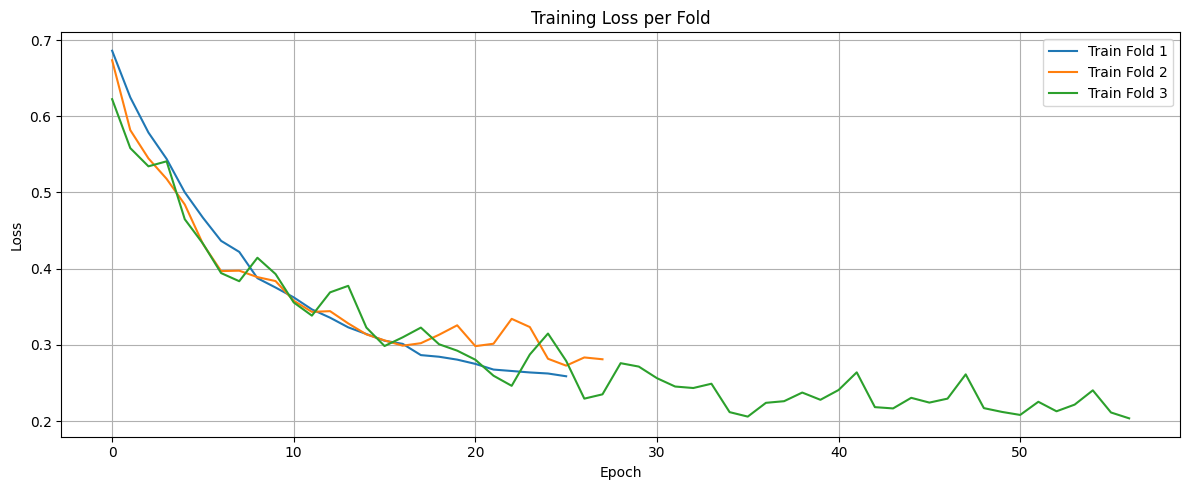

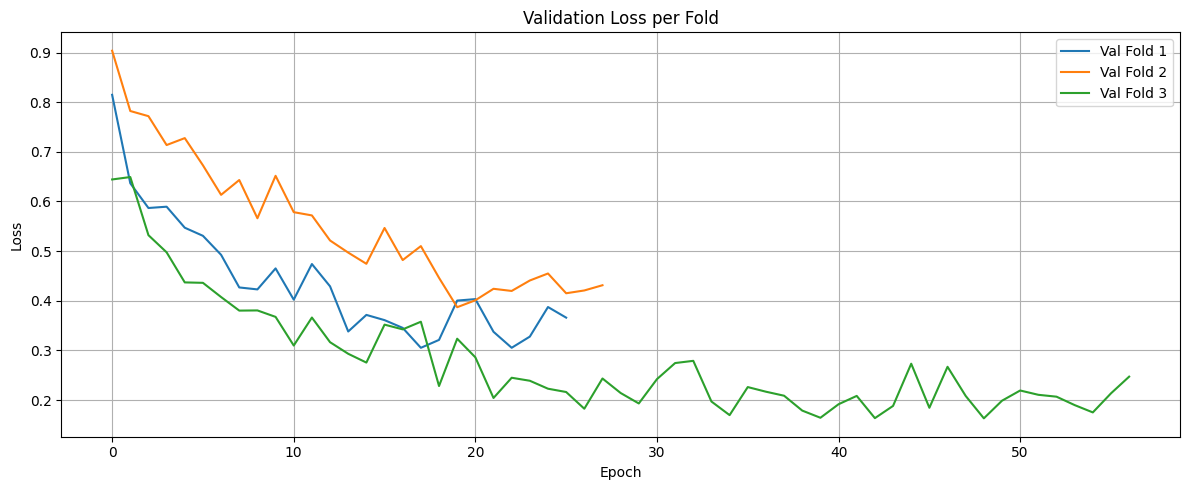


Walk-forward validation complete. Retraining model on full training data for final evaluation...
Retrain Epoch 5/85 - Loss: 0.2494
Retrain Epoch 10/85 - Loss: 0.1875
Retrain Epoch 15/85 - Loss: 0.1712
Retrain Epoch 20/85 - Loss: 0.1641
Retrain Epoch 25/85 - Loss: 0.1597
Retrain Epoch 30/85 - Loss: 0.1609
Retrain Epoch 35/85 - Loss: 0.1561
Retrain Epoch 40/85 - Loss: 0.1547
Retrain Epoch 45/85 - Loss: 0.1508
Retrain Epoch 50/85 - Loss: 0.1498
Retrain Epoch 55/85 - Loss: 0.1494
Retrain Epoch 60/85 - Loss: 0.1496
Retrain Epoch 65/85 - Loss: 0.1472
Retrain Epoch 70/85 - Loss: 0.1484
Retrain Epoch 75/85 - Loss: 0.1453
Retrain Epoch 80/85 - Loss: 0.1456
Retrain Epoch 85/85 - Loss: 0.1428


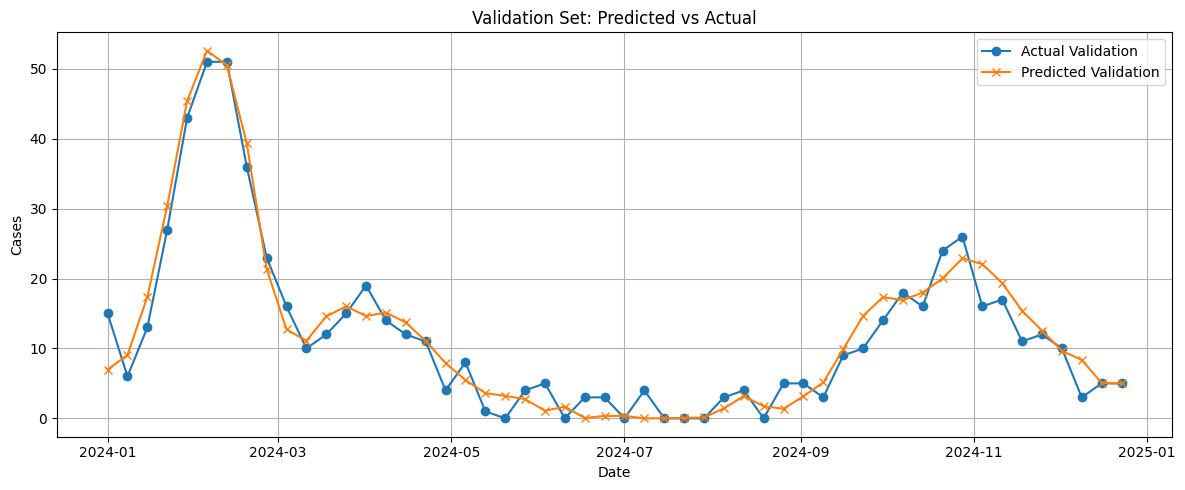


Final Validation MAE: 2.3609 for Kyiv
Final Validation R²: 0.9415 for Kyiv


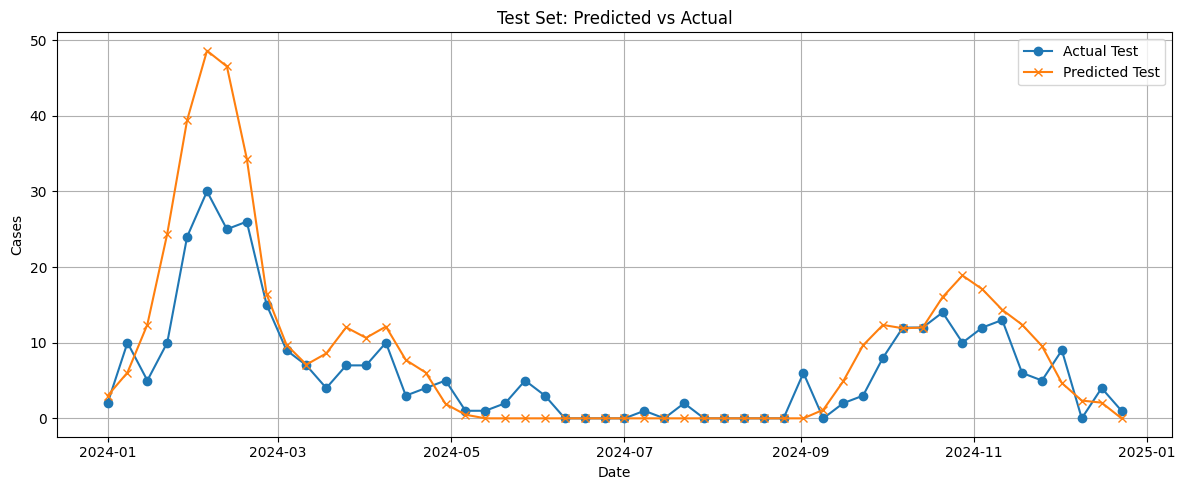


Final Test MAE: 3.6830 for Kyiv
Final Test R²: 0.3097 for Kyiv
Using device: cuda

Final Validation MAE: 2.8330 for KyivCity
Final Validation R²: 0.9150 for KyivCity

Final Test MAE: 3.1380 for KyivCity
Final Test R²: 0.7160 for KyivCity
Using device: cuda

Final Validation MAE: 2.6090 for Luhansk
Final Validation R²: 0.7740 for Luhansk

Final Test MAE: 2.9680 for Luhansk
Final Test R²: 0.5330 for Luhansk
Using device: cuda


Folds:   0%|          | 0/3 [00:00<?, ?it/s]

Fold 1/3 - Epoch 5/85 - Train Loss: 0.4869, Val Loss: 0.5406
Fold 1/3 - Epoch 10/85 - Train Loss: 0.3340, Val Loss: 0.3912
Fold 1/3 - Epoch 15/85 - Train Loss: 0.2880, Val Loss: 0.2925
Fold 1/3 - Epoch 20/85 - Train Loss: 0.2798, Val Loss: 0.2880
Fold 1/3 - Epoch 25/85 - Train Loss: 0.2355, Val Loss: 0.2801


Folds:  33%|███▎      | 1/3 [00:06<00:13,  6.71s/it]

Fold 2/3 - Epoch 5/85 - Train Loss: 0.4778, Val Loss: 0.7235
Fold 2/3 - Epoch 10/85 - Train Loss: 0.3623, Val Loss: 0.6174
Fold 2/3 - Epoch 15/85 - Train Loss: 0.3083, Val Loss: 0.4860
Fold 2/3 - Epoch 20/85 - Train Loss: 0.2748, Val Loss: 0.3987
Fold 2/3 - Epoch 25/85 - Train Loss: 0.2374, Val Loss: 0.3196
Fold 2/3 - Epoch 30/85 - Train Loss: 0.2571, Val Loss: 0.3721
Fold 2/3 - Epoch 35/85 - Train Loss: 0.2136, Val Loss: 0.3427
Fold 2/3 - Epoch 40/85 - Train Loss: 0.2291, Val Loss: 0.3689
Fold 2/3 - Epoch 45/85 - Train Loss: 0.2753, Val Loss: 0.3603


Folds:  67%|██████▋   | 2/3 [00:25<00:13, 13.72s/it]

Fold 3/3 - Epoch 5/85 - Train Loss: 0.4644, Val Loss: 0.4380
Fold 3/3 - Epoch 10/85 - Train Loss: 0.3149, Val Loss: 0.3290
Fold 3/3 - Epoch 15/85 - Train Loss: 0.3087, Val Loss: 0.2978
Fold 3/3 - Epoch 20/85 - Train Loss: 0.2536, Val Loss: 0.1837
Fold 3/3 - Epoch 25/85 - Train Loss: 0.2843, Val Loss: 0.1906
Fold 3/3 - Epoch 30/85 - Train Loss: 0.2306, Val Loss: 0.2575
Fold 3/3 - Epoch 35/85 - Train Loss: 0.2143, Val Loss: 0.1373


Folds: 100%|██████████| 3/3 [00:46<00:00, 15.34s/it]

Fold 3/3 - Epoch 40/85 - Train Loss: 0.1913, Val Loss: 0.1211


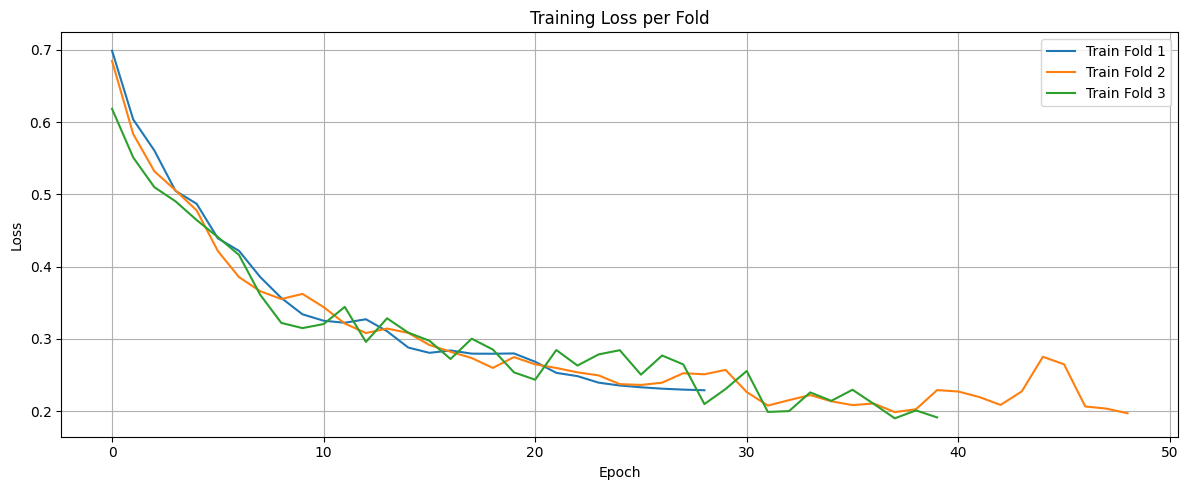

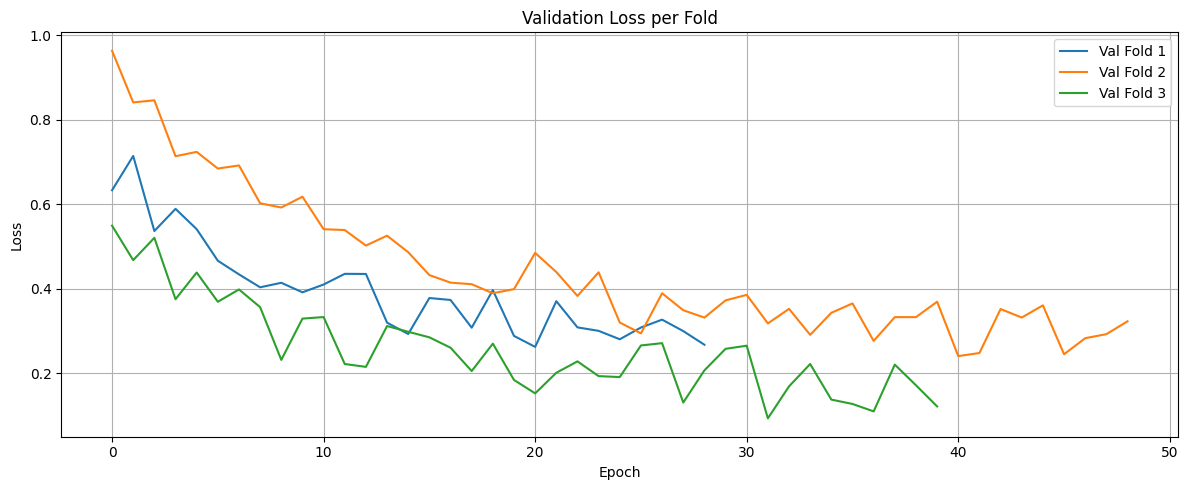


Walk-forward validation complete. Retraining model on full training data for final evaluation...
Retrain Epoch 5/85 - Loss: 0.2219
Retrain Epoch 10/85 - Loss: 0.1617
Retrain Epoch 15/85 - Loss: 0.1436
Retrain Epoch 20/85 - Loss: 0.1321
Retrain Epoch 25/85 - Loss: 0.1292
Retrain Epoch 30/85 - Loss: 0.1274
Retrain Epoch 35/85 - Loss: 0.1245
Retrain Epoch 40/85 - Loss: 0.1259
Retrain Epoch 45/85 - Loss: 0.1221
Retrain Epoch 50/85 - Loss: 0.1226
Retrain Epoch 55/85 - Loss: 0.1214
Retrain Epoch 60/85 - Loss: 0.1192
Retrain Epoch 65/85 - Loss: 0.1194
Retrain Epoch 70/85 - Loss: 0.1177
Retrain Epoch 75/85 - Loss: 0.1157
Retrain Epoch 80/85 - Loss: 0.1167
Retrain Epoch 85/85 - Loss: 0.1141


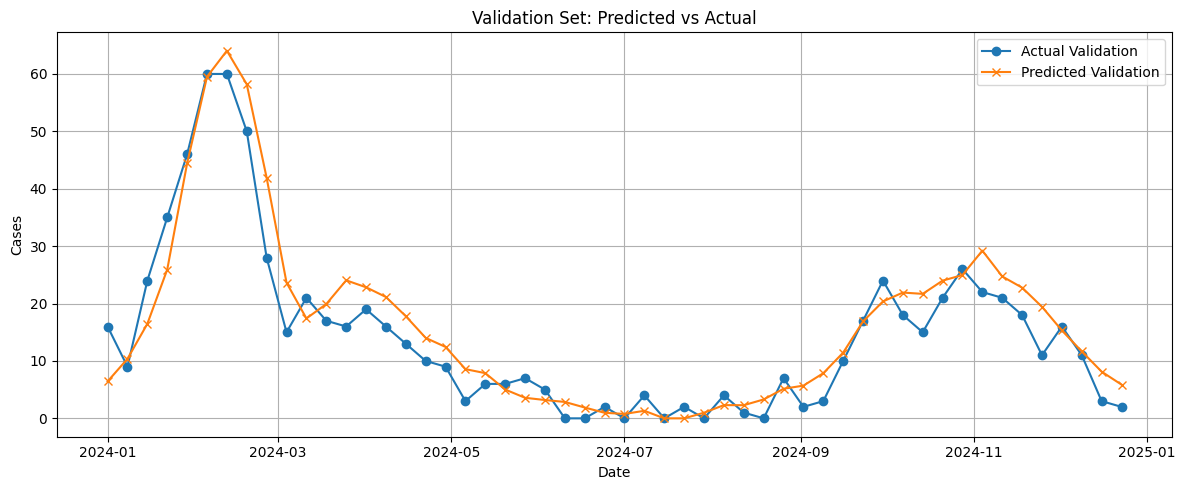


Final Validation MAE: 3.7897 for Lviv
Final Validation R²: 0.8895 for Lviv


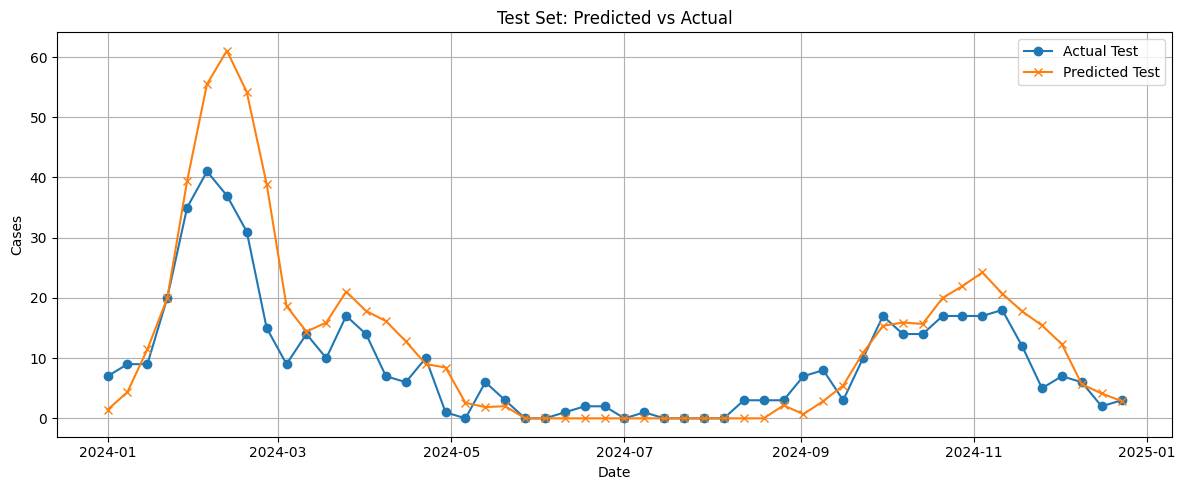


Final Test MAE: 4.4920 for Lviv
Final Test R²: 0.4425 for Lviv
Using device: cuda

Final Validation MAE: 2.0590 for Mykolaiv
Final Validation R²: 0.9380 for Mykolaiv

Final Test MAE: 2.3770 for Mykolaiv
Final Test R²: 0.6370 for Mykolaiv
Using device: cuda

Final Validation MAE: 2.8690 for Odessa
Final Validation R²: 0.9050 for Odessa

Final Test MAE: 3.1110 for Odessa
Final Test R²: 0.6560 for Odessa
Using device: cuda

Final Validation MAE: 2.3080 for Poltava
Final Validation R²: 0.6790 for Poltava

Final Test MAE: 2.6650 for Poltava
Final Test R²: 0.5750 for Poltava
Using device: cuda

Final Validation MAE: 2.3310 for Rivne
Final Validation R²: 0.7420 for Rivne

Final Test MAE: 2.7150 for Rivne
Final Test R²: 0.5070 for Rivne
Using device: cuda

Final Validation MAE: 2.1480 for Sumy
Final Validation R²: 0.8890 for Sumy

Final Test MAE: 2.3730 for Sumy
Final Test R²: 0.6230 for Sumy
Using device: cuda

Final Validation MAE: 2.3410 for Ternopil
Final Validation R²: 0.7630 for Ternopi

Folds:   0%|          | 0/3 [00:00<?, ?it/s]

Fold 1/3 - Epoch 5/85 - Train Loss: 0.4860, Val Loss: 0.5074
Fold 1/3 - Epoch 10/85 - Train Loss: 0.3653, Val Loss: 0.4769
Fold 1/3 - Epoch 15/85 - Train Loss: 0.3283, Val Loss: 0.3068
Fold 1/3 - Epoch 20/85 - Train Loss: 0.2905, Val Loss: 0.2792
Fold 1/3 - Epoch 25/85 - Train Loss: 0.2746, Val Loss: 0.3518
Fold 1/3 - Epoch 30/85 - Train Loss: 0.2591, Val Loss: 0.3131
Fold 1/3 - Epoch 35/85 - Train Loss: 0.2447, Val Loss: 0.2558


Folds:  33%|███▎      | 1/3 [00:09<00:18,  9.38s/it]

Fold 1/3 - Epoch 40/85 - Train Loss: 0.2458, Val Loss: 0.2464
Fold 2/3 - Epoch 5/85 - Train Loss: 0.4702, Val Loss: 0.6954
Fold 2/3 - Epoch 10/85 - Train Loss: 0.3586, Val Loss: 0.5305
Fold 2/3 - Epoch 15/85 - Train Loss: 0.3422, Val Loss: 0.4563
Fold 2/3 - Epoch 20/85 - Train Loss: 0.2969, Val Loss: 0.3678
Fold 2/3 - Epoch 25/85 - Train Loss: 0.2825, Val Loss: 0.3364
Fold 2/3 - Epoch 30/85 - Train Loss: 0.2740, Val Loss: 0.2750
Fold 2/3 - Epoch 35/85 - Train Loss: 0.2809, Val Loss: 0.4406


Folds:  67%|██████▋   | 2/3 [00:23<00:12, 12.19s/it]

Fold 3/3 - Epoch 5/85 - Train Loss: 0.4603, Val Loss: 0.4690
Fold 3/3 - Epoch 10/85 - Train Loss: 0.3766, Val Loss: 0.2736
Fold 3/3 - Epoch 15/85 - Train Loss: 0.3468, Val Loss: 0.2454
Fold 3/3 - Epoch 20/85 - Train Loss: 0.2510, Val Loss: 0.1622
Fold 3/3 - Epoch 25/85 - Train Loss: 0.2446, Val Loss: 0.2379
Fold 3/3 - Epoch 30/85 - Train Loss: 0.2180, Val Loss: 0.2217
Fold 3/3 - Epoch 35/85 - Train Loss: 0.2114, Val Loss: 0.1748


Folds: 100%|██████████| 3/3 [00:43<00:00, 14.56s/it]


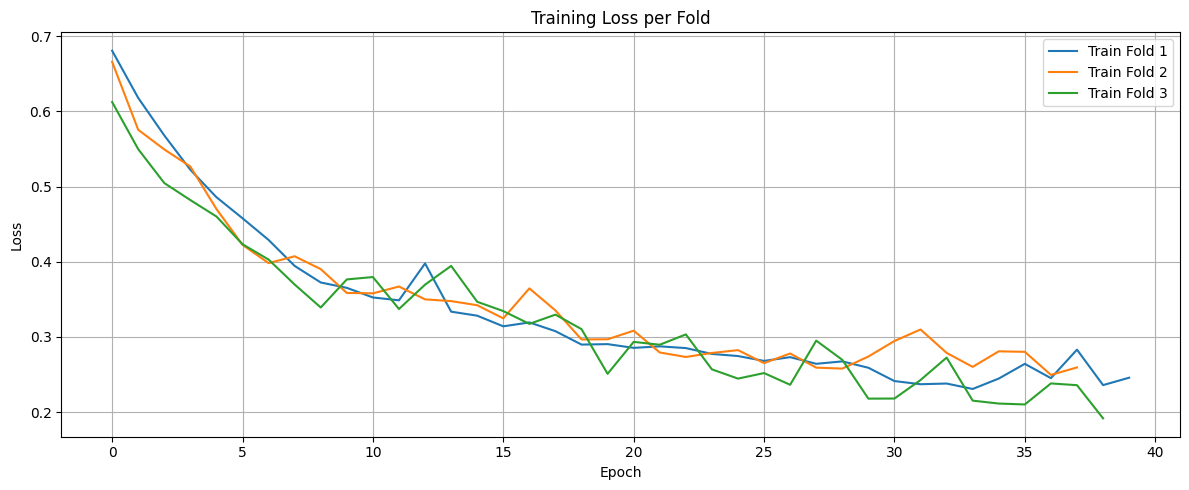

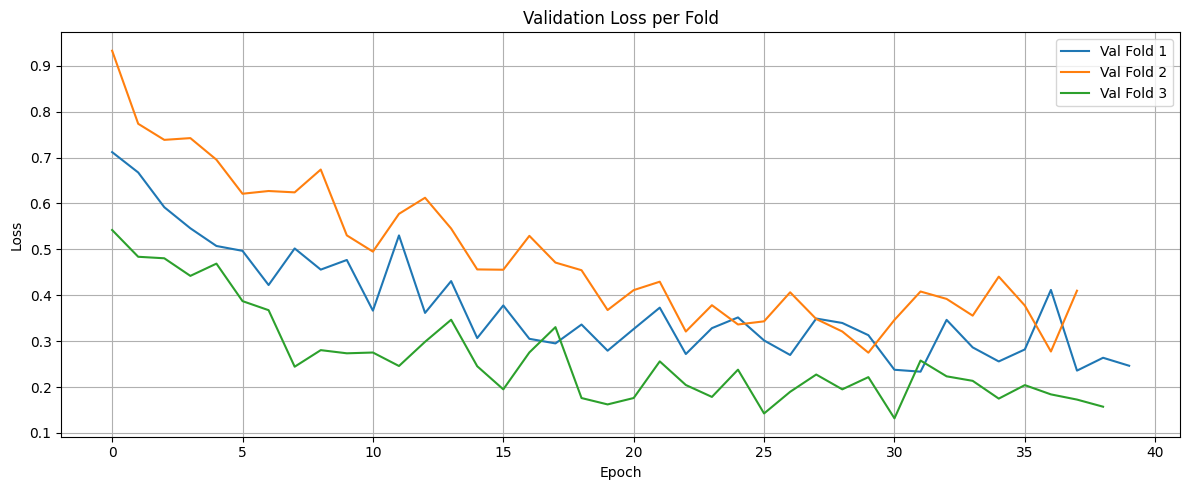


Walk-forward validation complete. Retraining model on full training data for final evaluation...
Retrain Epoch 5/85 - Loss: 0.2367
Retrain Epoch 10/85 - Loss: 0.1803
Retrain Epoch 15/85 - Loss: 0.1618
Retrain Epoch 20/85 - Loss: 0.1572
Retrain Epoch 25/85 - Loss: 0.1536
Retrain Epoch 30/85 - Loss: 0.1482
Retrain Epoch 35/85 - Loss: 0.1455
Retrain Epoch 40/85 - Loss: 0.1439
Retrain Epoch 45/85 - Loss: 0.1428
Retrain Epoch 50/85 - Loss: 0.1410
Retrain Epoch 55/85 - Loss: 0.1788
Retrain Epoch 60/85 - Loss: 0.1392
Retrain Epoch 65/85 - Loss: 0.1388
Retrain Epoch 70/85 - Loss: 0.1373
Retrain Epoch 75/85 - Loss: 0.1364
Retrain Epoch 80/85 - Loss: 0.1360
Retrain Epoch 85/85 - Loss: 0.1384


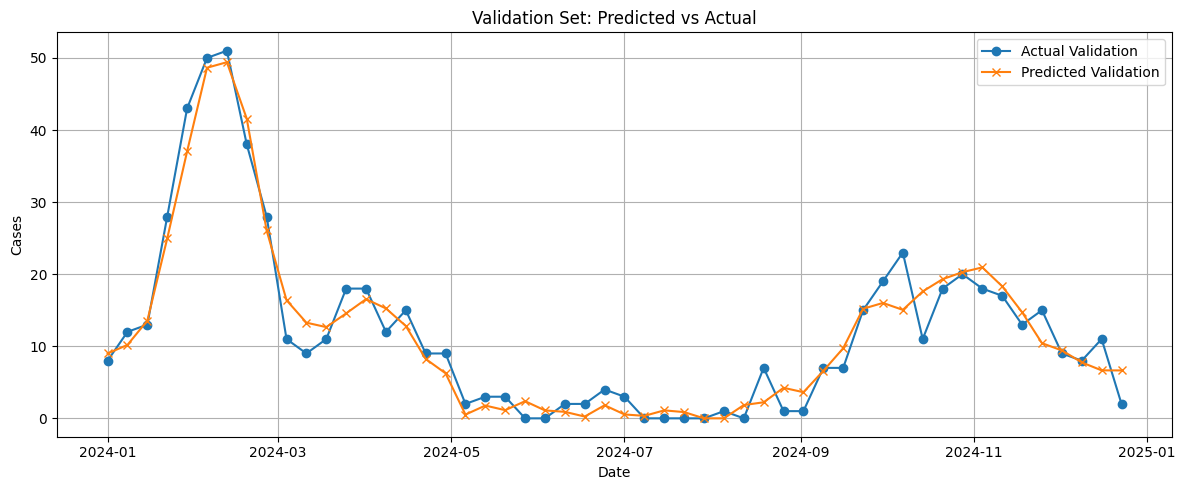


Final Validation MAE: 2.3077 for Zaporizhzhia
Final Validation R²: 0.9442 for Zaporizhzhia


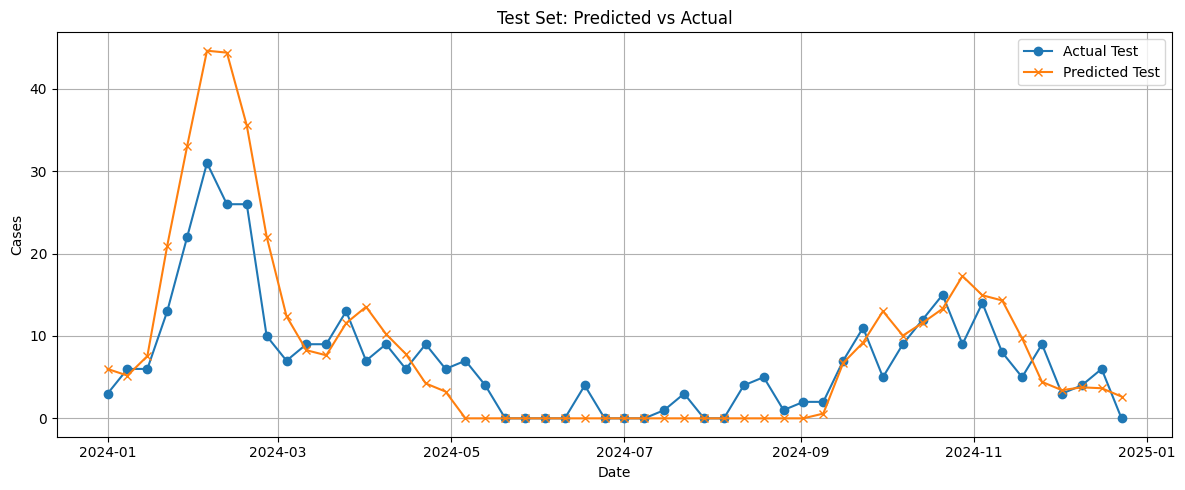


Final Test MAE: 3.4651 for Zaporizhzhia
Final Test R²: 0.4214 for Zaporizhzhia
Using device: cuda

Final Validation MAE: 2.3240 for Zhytomyr
Final Validation R²: 0.8420 for Zhytomyr

Final Test MAE: 2.8820 for Zhytomyr
Final Test R²: 0.6120 for Zhytomyr


In [ ]:
seq_length = 52
predict_length = 52
n_splits = 3
model_config = {
    'hidden_size': 200,
    'num_layers': 3,
    'dropout': 0.35
}
training_config = {
    'batch_size': 64,
    'lr': 0.001,
    'epochs': 85,
    'patience': 8,
    'weight_decay': 0.0001
}

for region in data_by_region.keys():
    if region == 'AR Crimea':
        continue

    region_data = data_by_region[region]['INFREL'].values

    gru_val_history, gru_test_history = full_gru_pipeline(region_data, seq_length, 
                    predict_length, n_splits, 
                    model_config, training_config, 
                    data_by_region[region]['DATE'][-predict_length:].values, 
                    region,
                    12)
    
    regions_mae_val[region] = gru_val_history['mae']
    regions_r2_val[region] = gru_val_history['r2']

    regions_mae_test[region] = gru_test_history['mae']
    regions_r2_test[region] = gru_test_history['r2']

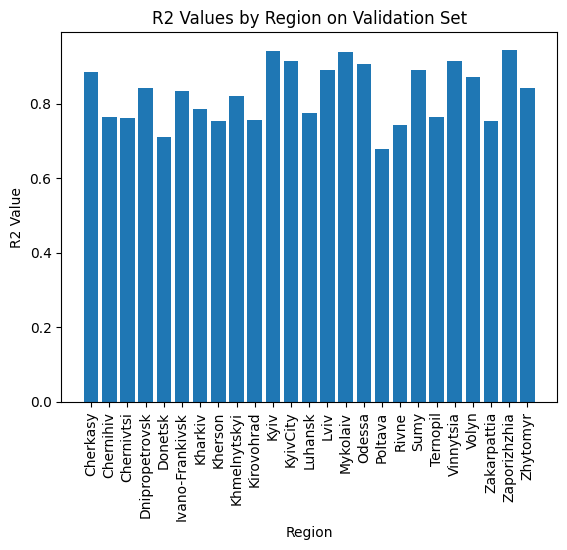

In [39]:
plt.bar(list(data_by_region.keys())[1:], np.array([regions_r2_val[region] for region in regions_r2_val.keys()]).clip(min=0))

plt.title('R2 Values by Region on Validation Set')
plt.xlabel('Region')
plt.ylabel('R2 Value')
plt.xticks(rotation=90)
plt.show()

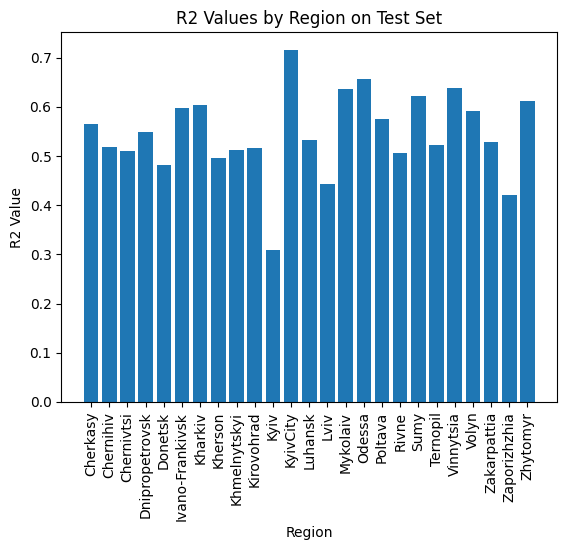

In [40]:
plt.bar(list(data_by_region.keys())[1:], np.array([regions_r2_test[region] for region in regions_r2_test.keys()]).clip(min=0))

plt.title('R2 Values by Region on Test Set')
plt.xlabel('Region')
plt.ylabel('R2 Value')
plt.xticks(rotation=90)
plt.show()

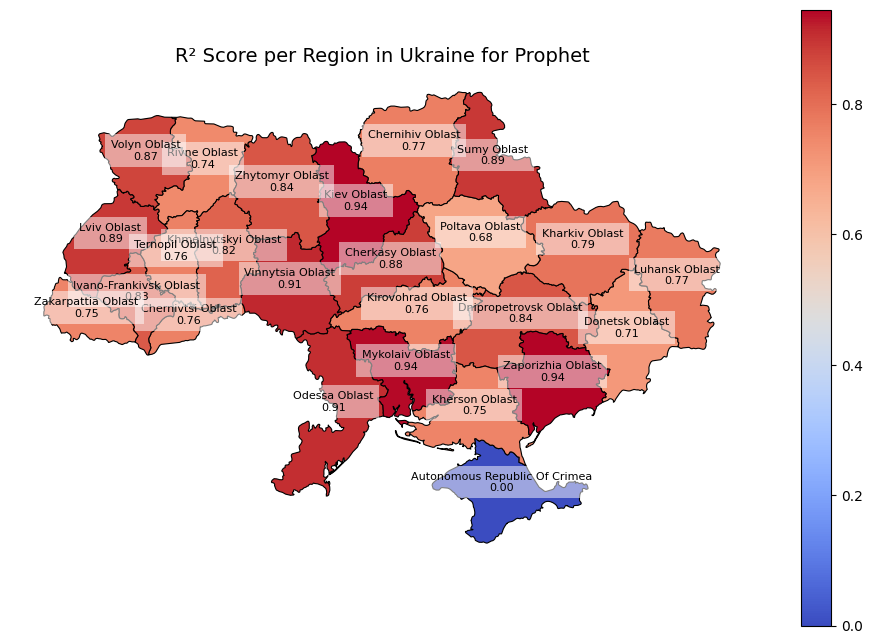

In [41]:
regions_to_r2_val = {f'{region} Oblast': max(0, float(regions_r2_val[region])) for region in regions_r2_val.keys() if region != 'KyivCity'}
plot_ukraine_r2_heatmap('D:/University/Diploma/data/UA_FULL_Ukraine.geojson', regions_to_r2_val)

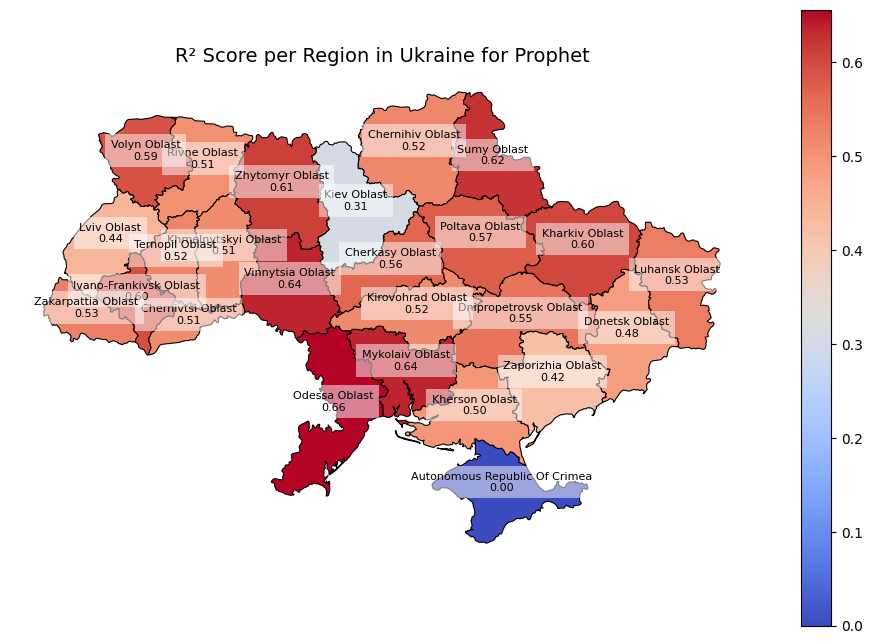

In [42]:
regions_to_r2_test = {f'{region} Oblast': max(0, float(regions_r2_test[region])) for region in regions_r2_test.keys() if region != 'KyivCity'}
plot_ukraine_r2_heatmap('D:/University/Diploma/data/UA_FULL_Ukraine.geojson', regions_to_r2_test)